## Start

In [1]:
import sys
print(sys.executable)


/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/.venv/bin/python


In [2]:
import nba_api
print("nba_api ok")




nba_api ok


## Injesting teams & players

In [3]:
import pandas as pd
from nba_api.stats.static import teams, players

teams_df = pd.DataFrame(teams.get_teams()).rename(columns={
    "id": "team_id",
    "full_name": "team_name",
    "abbreviation": "team_abbr"
})[["team_id", "team_name", "team_abbr"]]

players_df = pd.DataFrame(players.get_players()).rename(columns={
    "id": "player_id",
    "full_name": "player_name"
})[["player_id", "player_name"]]

teams_df.head(), players_df.head(), (len(teams_df), len(players_df))



(      team_id             team_name team_abbr
 0  1610612737         Atlanta Hawks       ATL
 1  1610612738        Boston Celtics       BOS
 2  1610612739   Cleveland Cavaliers       CLE
 3  1610612740  New Orleans Pelicans       NOP
 4  1610612741         Chicago Bulls       CHI,
    player_id          player_name
 0      76001       Alaa Abdelnaby
 1      76002      Zaid Abdul-Aziz
 2      76003  Kareem Abdul-Jabbar
 3         51   Mahmoud Abdul-Rauf
 4       1505    Tariq Abdul-Wahad,
 (30, 5103))

In [4]:
# save them to disk in my project under data/raw/
import os
os.makedirs("data/raw", exist_ok=True)

teams_df.to_csv("data/raw/teams.csv", index=False)
players_df.to_csv("data/raw/players.csv", index=False)

print("wrote:", "data/raw/teams.csv", "and", "data/raw/players.csv")


wrote: data/raw/teams.csv and data/raw/players.csv


In [5]:
# confirm that the files exist
import os
os.listdir("data/raw")[:10]


['teams.csv',
 'team_game_fact_2023_24_regular.csv',
 'pbp',
 'players.csv',
 'pbp_event_sample_0022300061.csv',
 'player_game_fact_2023_24_regular.csv']

## Ingesting Games + box score (currently only season 2023-2024)

In [6]:
# we will use only one season for now, 2023-2024 to see if the injection works well.

In [7]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamelog

season = "2023-24"

lg = leaguegamelog.LeagueGameLog(season=season, season_type_all_star="Regular Season")
team_games_raw = lg.get_data_frames()[0]

team_games_raw.columns, team_games_raw.head(3), team_games_raw.shape


(Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
        'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
        'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
        'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
       dtype='object'),
   SEASON_ID     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME     GAME_ID  \
 0     22023  1610612743               DEN         Denver Nuggets  0022300061   
 1     22023  1610612744               GSW  Golden State Warriors  0022300062   
 2     22023  1610612747               LAL     Los Angeles Lakers  0022300061   
 
     GAME_DATE      MATCHUP WL  MIN  FGM  ...  DREB  REB  AST  STL  BLK  TOV  \
 0  2023-10-24  DEN vs. LAL  W  240   48  ...    33   42   29    9    6   12   
 1  2023-10-24  GSW vs. PHX  L  240   36  ...    31   49   19   11    6   11   
 2  2023-10-24    LAL @ DEN  L  240   41  ...    31   44   23    5    4   12   
 
    PF  PTS  PLUS

In [8]:
# transform it into our canonical columns and add opponent_team_id + home_away

In [9]:
import pandas as pd

season = "2023-24"
league = "NBA"

df = team_games_raw.copy()

df = df.rename(columns={
    "SEASON_ID": "season_id_raw",
    "TEAM_ID": "team_id",
    "TEAM_ABBREVIATION": "team_abbr",
    "TEAM_NAME": "team_name",
    "GAME_ID": "game_id",
    "GAME_DATE": "game_date",
    "MATCHUP": "matchup",
    "WL": "wl",
    "MIN": "minutes",
    "FGM": "fgm",
    "FGA": "fga",
    "FG_PCT": "fg_pct",
    "FG3M": "fg3m",
    "FG3A": "fg3a",
    "FG3_PCT": "fg3_pct",
    "FTM": "ftm",
    "FTA": "fta",
    "FT_PCT": "ft_pct",
    "OREB": "oreb",
    "DREB": "dreb",
    "REB": "reb",
    "AST": "ast",
    "STL": "stl",
    "BLK": "blk",
    "TOV": "tov",
    "PF": "pf",
    "PTS": "pts",
    "PLUS_MINUS": "plus_minus",
    "VIDEO_AVAILABLE": "video_available",
})

df["league"] = league
df["season"] = season
df["game_date"] = pd.to_datetime(df["game_date"])

df["home_away"] = df["matchup"].apply(lambda s: "H" if "vs." in s else "A")
df["opp_abbr"] = df["matchup"].str.split().str[-1]

abbr_to_id = dict(zip(teams_df["team_abbr"], teams_df["team_id"]))
df["opponent_team_id"] = df["opp_abbr"].map(abbr_to_id)

team_game_fact = df[[
    "league","season","season_id_raw",
    "game_id","game_date",
    "team_id","team_abbr","team_name",
    "opponent_team_id","home_away","matchup","wl",
    "pts","minutes",
    "fgm","fga","fg_pct",
    "fg3m","fg3a","fg3_pct",
    "ftm","fta","ft_pct",
    "oreb","dreb","reb",
    "ast","tov","stl","blk","pf",
    "plus_minus",
    "video_available"
]].copy()

team_game_fact.head(), team_game_fact["opponent_team_id"].isna().sum()


(  league   season season_id_raw     game_id  game_date     team_id team_abbr  \
 0    NBA  2023-24         22023  0022300061 2023-10-24  1610612743       DEN   
 1    NBA  2023-24         22023  0022300062 2023-10-24  1610612744       GSW   
 2    NBA  2023-24         22023  0022300061 2023-10-24  1610612747       LAL   
 3    NBA  2023-24         22023  0022300062 2023-10-24  1610612756       PHX   
 4    NBA  2023-24         22023  0022300071 2023-10-25  1610612740       NOP   
 
                team_name  opponent_team_id home_away  ... oreb dreb  reb  ast  \
 0         Denver Nuggets        1610612747         H  ...    9   33   42   29   
 1  Golden State Warriors        1610612756         H  ...   18   31   49   19   
 2     Los Angeles Lakers        1610612743         A  ...   13   31   44   23   
 3           Phoenix Suns        1610612744         A  ...   17   43   60   23   
 4   New Orleans Pelicans        1610612763         A  ...   11   41   52   22   
 
    tov  stl  blk 

In [10]:
# saving team_game_fact to disk
team_game_fact.to_csv("data/raw/team_game_fact_2023_24_regular.csv", index=False)


In [11]:
import os
os.listdir("data/raw")[:10]

['teams.csv',
 'team_game_fact_2023_24_regular.csv',
 'pbp',
 'players.csv',
 'pbp_event_sample_0022300061.csv',
 'player_game_fact_2023_24_regular.csv']

## Injesting player game logs for 2023-24 regular season

In [12]:
from nba_api.stats.endpoints import leaguegamelog
import pandas as pd

season = "2023-24"

lg_players = leaguegamelog.LeagueGameLog(
    season=season,
    season_type_all_star="Regular Season",
    player_or_team_abbreviation="P"
)
player_games_raw = lg_players.get_data_frames()[0]

player_games_raw.columns, player_games_raw.head(3), player_games_raw.shape


(Index(['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
        'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM',
        'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
        'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
        'PLUS_MINUS', 'FANTASY_PTS', 'VIDEO_AVAILABLE'],
       dtype='object'),
   SEASON_ID  PLAYER_ID     PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION  \
 0     22023     202704  Reggie Jackson  1610612743               DEN   
 1     22023     203932    Aaron Gordon  1610612743               DEN   
 2     22023     203999    Nikola Jokić  1610612743               DEN   
 
         TEAM_NAME     GAME_ID   GAME_DATE      MATCHUP WL  ...  REB  AST  STL  \
 0  Denver Nuggets  0022300061  2023-10-24  DEN vs. LAL  W  ...    3    1    1   
 1  Denver Nuggets  0022300061  2023-10-24  DEN vs. LAL  W  ...    7    5    2   
 2  Denver Nuggets  0022300061  2023-10-24  DEN vs. LAL  W  ...   13   11 

In [13]:
import pandas as pd

season = "2023-24"
league = "NBA"

df = player_games_raw.copy()

df = df.rename(columns={
    "SEASON_ID": "season_id_raw",
    "PLAYER_ID": "player_id",
    "PLAYER_NAME": "player_name",
    "TEAM_ID": "team_id",
    "TEAM_ABBREVIATION": "team_abbr",
    "TEAM_NAME": "team_name",
    "GAME_ID": "game_id",
    "GAME_DATE": "game_date",
    "MATCHUP": "matchup",
    "WL": "wl",
    "MIN": "minutes",
    "FGM": "fgm",
    "FGA": "fga",
    "FG_PCT": "fg_pct",
    "FG3M": "fg3m",
    "FG3A": "fg3a",
    "FG3_PCT": "fg3_pct",
    "FTM": "ftm",
    "FTA": "fta",
    "FT_PCT": "ft_pct",
    "OREB": "oreb",
    "DREB": "dreb",
    "REB": "reb",
    "AST": "ast",
    "STL": "stl",
    "BLK": "blk",
    "TOV": "tov",
    "PF": "pf",
    "PTS": "pts",
    "PLUS_MINUS": "plus_minus",
    "FANTASY_PTS": "fantasy_pts",
    "VIDEO_AVAILABLE": "video_available",
})

df["league"] = league
df["season"] = season
df["game_date"] = pd.to_datetime(df["game_date"])

df["home_away"] = df["matchup"].apply(lambda s: "H" if "vs." in s else "A")
df["opp_abbr"] = df["matchup"].str.split().str[-1]

abbr_to_id = dict(zip(teams_df["team_abbr"], teams_df["team_id"]))
df["opponent_team_id"] = df["opp_abbr"].map(abbr_to_id)

# Position not in this endpoint; we’ll join later from roster/season info.
df["position"] = None

player_game_fact = df[[
    "league","season","season_id_raw",
    "game_id","game_date",
    "player_id","player_name",
    "team_id","team_abbr","team_name",
    "opponent_team_id","home_away","matchup","wl",
    "position",
    "pts","minutes",
    "fgm","fga","fg_pct",
    "fg3m","fg3a","fg3_pct",
    "ftm","fta","ft_pct",
    "oreb","dreb","reb",
    "ast","tov","stl","blk","pf",
    "plus_minus","fantasy_pts",
    "video_available"
]].copy()

player_game_fact.head(), player_game_fact["opponent_team_id"].isna().sum()


(  league   season season_id_raw     game_id  game_date  player_id  \
 0    NBA  2023-24         22023  0022300061 2023-10-24     202704   
 1    NBA  2023-24         22023  0022300061 2023-10-24     203932   
 2    NBA  2023-24         22023  0022300061 2023-10-24     203999   
 3    NBA  2023-24         22023  0022300061 2023-10-24    1629008   
 4    NBA  2023-24         22023  0022300061 2023-10-24    1629618   
 
           player_name     team_id team_abbr       team_name  ...  dreb reb  \
 0      Reggie Jackson  1610612743       DEN  Denver Nuggets  ...     3   3   
 1        Aaron Gordon  1610612743       DEN  Denver Nuggets  ...     5   7   
 2        Nikola Jokić  1610612743       DEN  Denver Nuggets  ...    10  13   
 3  Michael Porter Jr.  1610612743       DEN  Denver Nuggets  ...    10  12   
 4       Jalen Pickett  1610612743       DEN  Denver Nuggets  ...     0   0   
 
   ast tov stl  blk  pf  plus_minus  fantasy_pts  video_available  
 0   1   2   1    0   0          1

In [14]:
player_game_fact.to_csv("data/raw/player_game_fact_2023_24_regular.csv", index=False)


In [15]:
import os
os.listdir("data/raw")[:10]

['teams.csv',
 'team_game_fact_2023_24_regular.csv',
 'pbp',
 'players.csv',
 'pbp_event_sample_0022300061.csv',
 'player_game_fact_2023_24_regular.csv']

## Injesting Play-by-Play stats

What we’ll use:
- nba_api.stats.endpoints.playbyplayv3 (newer, structured). If it fails, we fall back to playbyplay.

In [16]:
# grabbing a sample game
sample_game_id = team_game_fact["game_id"].iloc[0]
sample_game_id


'0022300061'

### Single-game smoke pull first, then generalize

In [17]:
from nba_api.stats.endpoints import playbyplayv3
import pandas as pd

game_id = "0022300061"

pbp = playbyplayv3.PlayByPlayV3(game_id=game_id)
pbp_raw = pbp.get_data_frames()[0]

pbp_raw.columns, pbp_raw.head(5), pbp_raw.shape


(Index(['gameId', 'actionNumber', 'clock', 'period', 'teamId', 'teamTricode',
        'personId', 'playerName', 'playerNameI', 'xLegacy', 'yLegacy',
        'shotDistance', 'shotResult', 'isFieldGoal', 'scoreHome', 'scoreAway',
        'pointsTotal', 'location', 'description', 'actionType', 'subType',
        'videoAvailable', 'shotValue', 'actionId'],
       dtype='object'),
        gameId  actionNumber        clock  period      teamId teamTricode  \
 0  0022300061             2  PT12M00.00S       1           0               
 1  0022300061             4  PT12M00.00S       1  1610612743         DEN   
 2  0022300061             7  PT11M42.00S       1  1610612747         LAL   
 3  0022300061            10  PT11M15.00S       1  1610612743         DEN   
 4  0022300061            11  PT10M57.00S       1  1610612747         LAL   
 
    personId playerName playerNameI  xLegacy  ...  scoreHome  scoreAway  \
 0         0                               0  ...          0          0   
 1    2

In [18]:
# we now create pbp_event for that game

In [19]:
import pandas as pd

league = "NBA"
season = "2023-24"
game_id = "0022300061"

df = pbp_raw.copy()

pbp_event = pd.DataFrame({
    "league": league,
    "season": season,
    "game_id": df["gameId"].astype(str),
    "event_id": df["actionNumber"].astype(int),
    "period": df["period"].astype(int),
    "clock": df["clock"],                      # keep raw clock string for now
    "team_id": df["teamId"],                   # nullable
    "player_id": df["personId"],               # nullable
    "player_name": df["playerName"],           # display/debug
    "event_type": df["actionType"],
    "event_subtype": df["subType"],
    "points": df["shotValue"].fillna(0).astype(int),
    "description": df["description"],
    "score_home": df["scoreHome"],
    "score_away": df["scoreAway"],
})

pbp_event.head(10), pbp_event.shape


(  league   season     game_id  event_id  period        clock     team_id  \
 0    NBA  2023-24  0022300061         2       1  PT12M00.00S           0   
 1    NBA  2023-24  0022300061         4       1  PT12M00.00S  1610612743   
 2    NBA  2023-24  0022300061         7       1  PT11M42.00S  1610612747   
 3    NBA  2023-24  0022300061        10       1  PT11M15.00S  1610612743   
 4    NBA  2023-24  0022300061        11       1  PT10M57.00S  1610612747   
 5    NBA  2023-24  0022300061        13       1  PT10M40.00S  1610612743   
 6    NBA  2023-24  0022300061        14       1  PT10M33.00S  1610612747   
 7    NBA  2023-24  0022300061        16       1  PT10M16.00S  1610612743   
 8    NBA  2023-24  0022300061        18       1  PT10M03.00S  1610612747   
 9    NBA  2023-24  0022300061        19       1  PT10M01.00S  1610612747   
 
    player_id player_name   event_type                   event_subtype  points  \
 0          0                   period                           star

In [20]:
pbp_event.to_csv("data/raw/pbp_event_sample_0022300061.csv", index=False)


In [21]:
# confirm that the files exist
import os
os.listdir("data/raw")[:10]

['teams.csv',
 'team_game_fact_2023_24_regular.csv',
 'pbp',
 'players.csv',
 'pbp_event_sample_0022300061.csv',
 'player_game_fact_2023_24_regular.csv']

### We now proceed with creating the pbp_event file for the whole 2023-2024 season

In [23]:
import time
import random
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import playbyplayv3

season = "2023-24"
league = "NBA"

PROJECT_ROOT = Path.cwd().parent
out_dir = PROJECT_ROOT / "data" / "raw" / "pbp" / f"season={season}"
out_dir.mkdir(parents=True, exist_ok=True)

game_ids = team_game_fact["game_id"].astype(str).drop_duplicates().tolist()
print("games to fetch:", len(game_ids))
print("output dir:", out_dir)

def fetch_one_game(game_id: str) -> pd.DataFrame:
    pbp = playbyplayv3.PlayByPlayV3(game_id=game_id, timeout=20)
    df = pbp.get_data_frames()[0]
    df.insert(0, "league", league)
    df.insert(1, "season", season)
    return df

failed = []
skipped = 0
saved = 0

for i, gid in enumerate(game_ids, start=1):
    out_path = out_dir / f"game_id={gid}.csv"
    if out_path.exists():
        skipped += 1
        continue

    ok = False
    for attempt in range(1, 6):
        try:
            df = fetch_one_game(gid)
            df.to_csv(out_path, index=False)
            saved += 1
            ok = True
            break
        except Exception:
            time.sleep(min(30, 2 ** attempt) + random.uniform(0.1, 0.7))

    if not ok:
        failed.append(gid)

    time.sleep(0.25 + random.uniform(0.05, 0.2))

    if i % 25 == 0:
        print(f"progress: {i}/{len(game_ids)} | saved={saved} skipped={skipped} failed={len(failed)}")

if failed:
    pd.DataFrame({"game_id": failed}).to_csv(out_dir / "_failed_game_ids.csv", index=False)

print("done:", {"saved": saved, "skipped": skipped, "failed": len(failed), "out_dir": str(out_dir)})


games to fetch: 1230
output dir: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/raw/pbp/season=2023-24
progress: 600/1230 | saved=1 skipped=599 failed=0
progress: 725/1230 | saved=6 skipped=719 failed=0
progress: 750/1230 | saved=31 skipped=719 failed=0
progress: 775/1230 | saved=56 skipped=719 failed=0
progress: 800/1230 | saved=81 skipped=719 failed=0
progress: 825/1230 | saved=106 skipped=719 failed=0
progress: 850/1230 | saved=131 skipped=719 failed=0
progress: 875/1230 | saved=156 skipped=719 failed=0
progress: 900/1230 | saved=181 skipped=719 failed=0
progress: 925/1230 | saved=206 skipped=719 failed=0
progress: 950/1230 | saved=231 skipped=719 failed=0
progress: 975/1230 | saved=256 skipped=719 failed=0
progress: 1000/1230 | saved=281 skipped=719 failed=0
progress: 1025/1230 | saved=306 skipped=719 failed=0
progress: 1050/1230 | saved=331 skipped=719 failed=0
progress: 1075/1230 | saved=356 skipped=719 failed=0
progress: 1100/1230 | saved=381 skipp

In [24]:
# building the canonical pbp_event_2023_24 by reading those per-game raw CSVs and mapping columns.

In [25]:
import pandas as pd
from pathlib import Path
import glob

season = "2023-24"
league = "NBA"

PROJECT_ROOT = Path.cwd().parent
in_dir = PROJECT_ROOT / "data" / "raw" / "pbp" / f"season={season}"
out_path = PROJECT_ROOT / "data" / "processed" / f"pbp_event_{season}_regular.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)

files = sorted(glob.glob(str(in_dir / "game_id=*.csv")))
print("files:", len(files))

chunks = []
for f in files:
    df = pd.read_csv(f)
    chunks.append(pd.DataFrame({
        "league": df["league"],
        "season": df["season"],
        "game_id": df["gameId"].astype(str),
        "event_id": df["actionNumber"].astype(int),
        "period": df["period"].astype(int),
        "clock": df["clock"],
        "team_id": df["teamId"],
        "player_id": df["personId"],
        "event_type": df["actionType"],
        "event_subtype": df["subType"],
        "description": df["description"],
        "score_home": df["scoreHome"],
        "score_away": df["scoreAway"],
    }))

pbp_event = pd.concat(chunks, ignore_index=True)
pbp_event.to_csv(out_path, index=False)

pbp_event.shape, out_path


files: 1230


((598705, 13),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/pbp_event_2023-24_regular.csv'))

## Shot charts & Dimension building

### Dimensions: Shot diet & shooting efficiency

#### Single-player smoke test using ShotChartDetail

In [27]:
from nba_api.stats.endpoints import shotchartdetail
import pandas as pd

season = "2023-24"

# Smoke test: Nikola Jokic, Denver
player_id = 203999
team_id = 1610612743

sc = shotchartdetail.ShotChartDetail(
    team_id=team_id,
    player_id=player_id,
    season_nullable=season,
    season_type_all_star="Regular Season",
    context_measure_simple="FGA"
)

shots_raw = sc.get_data_frames()[0]

shots_raw.shape, shots_raw.columns.tolist()[:25], shots_raw.head(3)


((1411, 24),
 ['GRID_TYPE',
  'GAME_ID',
  'GAME_EVENT_ID',
  'PLAYER_ID',
  'PLAYER_NAME',
  'TEAM_ID',
  'TEAM_NAME',
  'PERIOD',
  'MINUTES_REMAINING',
  'SECONDS_REMAINING',
  'EVENT_TYPE',
  'ACTION_TYPE',
  'SHOT_TYPE',
  'SHOT_ZONE_BASIC',
  'SHOT_ZONE_AREA',
  'SHOT_ZONE_RANGE',
  'SHOT_DISTANCE',
  'LOC_X',
  'LOC_Y',
  'SHOT_ATTEMPTED_FLAG',
  'SHOT_MADE_FLAG',
  'GAME_DATE',
  'HTM',
  'VTM'],
            GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID   PLAYER_NAME  \
 0  Shot Chart Detail  0022300006             14     203999  Nikola Jokić   
 1  Shot Chart Detail  0022300006             29     203999  Nikola Jokić   
 2  Shot Chart Detail  0022300006             66     203999  Nikola Jokić   
 
       TEAM_ID       TEAM_NAME  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
 0  1610612743  Denver Nuggets       1                 10                 55   
 1  1610612743  Denver Nuggets       1                  9                  7   
 2  1610612743  Denver Nuggets       1    

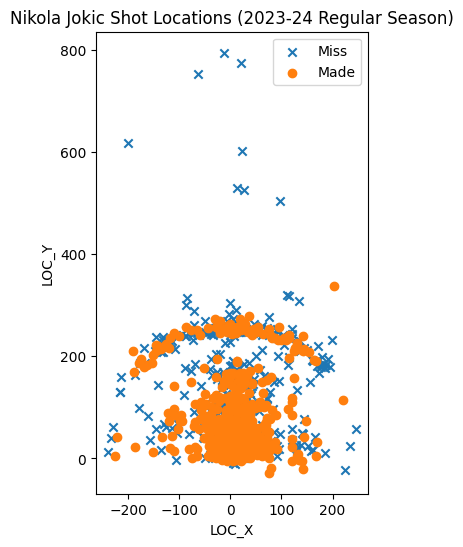

In [28]:
# let's build a visualization for fun
import matplotlib.pyplot as plt

df = shots_raw.copy()
made = df[df["SHOT_MADE_FLAG"] == 1]
miss = df[df["SHOT_MADE_FLAG"] == 0]

plt.figure(figsize=(7,6))
plt.scatter(miss["LOC_X"], miss["LOC_Y"], marker="x", label="Miss")
plt.scatter(made["LOC_X"], made["LOC_Y"], marker="o", label="Made")
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
plt.title("Nikola Jokic Shot Locations (2023-24 Regular Season)")
plt.legend()
plt.show()


In [32]:
# Defining functions for drawing basketball half-court and plotting shots on that court

In [29]:
# plotting by layering the court
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

def draw_half_court(ax=None, color="black", lw=1):
    if ax is None:
        ax = plt.gca()

    # NBA hoop is at (0, 0) in nba_api LOC coords
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, edgecolor=color, facecolor="none")
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, edgecolor=color, facecolor="none")

    # Paint (lane)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, edgecolor=color, facecolor="none")
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, edgecolor=color, facecolor="none")

    # Free throw arcs
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, edgecolor=color)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, edgecolor=color, linestyle="dashed")

    # Restricted area arc
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, edgecolor=color)

    # Three point line (approx in this coord system)
    corner_left = Rectangle((-220, -47.5), 0, 140, linewidth=lw, edgecolor=color, facecolor="none")
    corner_right = Rectangle((220, -47.5), 0, 140, linewidth=lw, edgecolor=color, facecolor="none")
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, edgecolor=color)

    # Center court (not visible in half-court usually, skip)

    for item in [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw,
                 restricted, corner_left, corner_right, three_arc]:
        ax.add_patch(item)

    return ax

def plot_shots_with_court(shots_df, title="Shot Chart"):
    made = shots_df[shots_df["SHOT_MADE_FLAG"] == 1]
    miss = shots_df[shots_df["SHOT_MADE_FLAG"] == 0]

    fig, ax = plt.subplots(figsize=(7,6))
    draw_half_court(ax=ax, lw=1)

    ax.scatter(miss["LOC_X"], miss["LOC_Y"], marker="x", label="Miss")
    ax.scatter(made["LOC_X"], made["LOC_Y"], marker="o", label="Made")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-250, 250)
    ax.set_ylim(-60, 470)
    ax.set_xlabel("LOC_X")
    ax.set_ylabel("LOC_Y")
    ax.set_title(title)
    ax.legend()
    plt.show()

# Example:
# plot_shots_with_court(shots_raw, "Nikola Jokic Shot Chart (2023-24)")


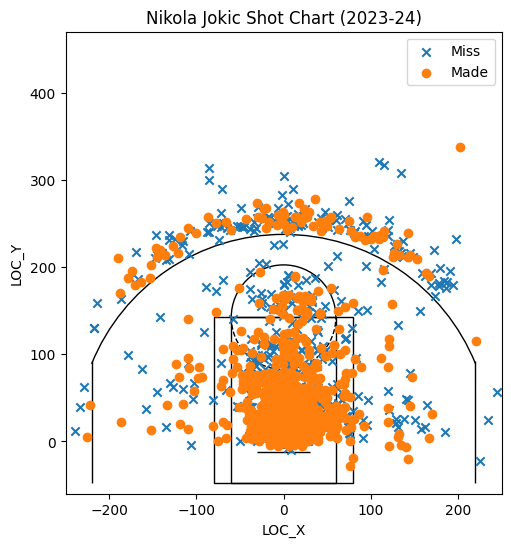

In [31]:
%matplotlib inline
plot_shots_with_court(shots_raw, "Nikola Jokic Shot Chart (2023-24)")


#### Build season-level shot_event for 2023-24.

- Getting the list of active players in 2023-24 from your player_game_fact_2023_24_regular.csv (unique player_id).

- For each player_id, calling ShotChartDetail with team_id=0 (all teams) and save one CSV per player under data/raw/shots/season=2023-24/.

- Concatenating later into one shot_event_2023_24.csv.

In [33]:
import time, random
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import shotchartdetail

season = "2023-24"
league = "NBA"

# project root (assumes notebook is in /notebooks)
PROJECT_ROOT = Path.cwd().parent
out_dir = PROJECT_ROOT / "data" / "raw" / "shots" / f"season={season}"
out_dir.mkdir(parents=True, exist_ok=True)

# Get player_ids for this season from your saved player_game_fact
pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
player_game_fact = pd.read_csv(pg_path)

player_ids = sorted(player_game_fact["player_id"].dropna().astype(int).unique().tolist())
print("players to fetch:", len(player_ids))
print("output dir:", out_dir)

def fetch_player_shots(pid: int) -> pd.DataFrame:
    sc = shotchartdetail.ShotChartDetail(
        team_id=0,                       # all teams (handles trades)
        player_id=pid,
        season_nullable=season,
        season_type_all_star="Regular Season",
        context_measure_simple="FGA",
        timeout=20
    )
    df = sc.get_data_frames()[0]
    df.insert(0, "league", league)
    df.insert(1, "season", season)
    return df

failed = []
skipped = 0
saved = 0

for i, pid in enumerate(player_ids, start=1):
    out_path = out_dir / f"player_id={pid}.csv"
    if out_path.exists():
        skipped += 1
        continue

    ok = False
    for attempt in range(1, 6):
        try:
            df = fetch_player_shots(pid)
            df.to_csv(out_path, index=False)
            saved += 1
            ok = True
            break
        except Exception:
            time.sleep(min(30, 2 ** attempt) + random.uniform(0.1, 0.7))

    if not ok:
        failed.append(pid)

    time.sleep(0.25 + random.uniform(0.05, 0.25))

    if i % 50 == 0:
        print(f"progress: {i}/{len(player_ids)} | saved={saved} skipped={skipped} failed={len(failed)}")

if failed:
    pd.DataFrame({"player_id": failed}).to_csv(out_dir / "_failed_player_ids.csv", index=False)

print("done:", {"saved": saved, "skipped": skipped, "failed": len(failed), "out_dir": str(out_dir)})


players to fetch: 572
output dir: /Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/raw/shots/season=2023-24
progress: 50/572 | saved=50 skipped=0 failed=0
progress: 100/572 | saved=100 skipped=0 failed=0
progress: 150/572 | saved=150 skipped=0 failed=0
progress: 200/572 | saved=200 skipped=0 failed=0
progress: 250/572 | saved=250 skipped=0 failed=0
progress: 300/572 | saved=300 skipped=0 failed=0
progress: 350/572 | saved=350 skipped=0 failed=0
progress: 400/572 | saved=400 skipped=0 failed=0
progress: 450/572 | saved=450 skipped=0 failed=0
progress: 500/572 | saved=500 skipped=0 failed=0
progress: 550/572 | saved=550 skipped=0 failed=0
done: {'saved': 572, 'skipped': 0, 'failed': 0, 'out_dir': '/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/raw/shots/season=2023-24'}


In [36]:
# merging those per-player files into one canonical shot_event table and save to data/processed/

In [37]:
import pandas as pd
from pathlib import Path
import glob

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

in_dir = PROJECT_ROOT / "data" / "raw" / "shots" / f"season={season}"
files = sorted(glob.glob(str(in_dir / "player_id=*.csv")))
print("files:", len(files))

chunks = []
for f in files:
    df = pd.read_csv(f)
    chunks.append(pd.DataFrame({
        "league": df["league"],
        "season": df["season"],
        "game_id": df["GAME_ID"].astype(str),
        "event_id": df["GAME_EVENT_ID"].astype(int),
        "game_date": pd.to_datetime(df["GAME_DATE"]),
        "team_id": df["TEAM_ID"],
        "player_id": df["PLAYER_ID"],
        "period": df["PERIOD"],
        "minutes_remaining": df["MINUTES_REMAINING"],
        "seconds_remaining": df["SECONDS_REMAINING"],
        "shot_type": df["SHOT_TYPE"],
        "action_type": df["ACTION_TYPE"],
        "shot_zone_basic": df["SHOT_ZONE_BASIC"],
        "shot_zone_area": df["SHOT_ZONE_AREA"],
        "shot_zone_range": df["SHOT_ZONE_RANGE"],
        "shot_distance": df["SHOT_DISTANCE"],
        "loc_x": df["LOC_X"],
        "loc_y": df["LOC_Y"],
        "shot_attempted": df["SHOT_ATTEMPTED_FLAG"],
        "shot_made": df["SHOT_MADE_FLAG"],
        "htm": df["HTM"],
        "vtm": df["VTM"],
    }))

shot_event = pd.concat(chunks, ignore_index=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
shot_event.to_csv(out_path, index=False)

shot_event.shape, out_path


files: 572


((218700, 22),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/shot_event_2023-24_regular.csv'))

#### Creating player_shot_profile_season_2023-24.csv

In [38]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent  # notebook is in /notebooks
shot_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"

shot_event = pd.read_csv(shot_path)

# Flags using NBA zone labels
shot_event["is_three"]   = shot_event["shot_zone_basic"].isin(["Above the Break 3", "Corner 3"])
shot_event["is_corner3"] = shot_event["shot_zone_basic"].eq("Corner 3")
shot_event["is_rim"]     = shot_event["shot_zone_basic"].eq("Restricted Area")
shot_event["is_mid"]     = shot_event["shot_zone_basic"].isin(["In The Paint (Non-RA)", "Mid-Range"])

# Aggregate counts (no fancy lambdas; do it with filtered groupbys)
keys = ["league", "season", "player_id"]

base = shot_event.groupby(keys, as_index=False).agg(
    fga=("shot_attempted", "sum"),
    fgm=("shot_made", "sum"),
)

def agg_zone(mask, prefix):
    tmp = shot_event.loc[mask].groupby(keys, as_index=False).agg(
        **{f"{prefix}_fga": ("shot_attempted", "sum"),
           f"{prefix}_fgm": ("shot_made", "sum")}
    )
    return tmp

three  = agg_zone(shot_event["is_three"], "three")
corner = agg_zone(shot_event["is_corner3"], "corner3")
rim    = agg_zone(shot_event["is_rim"], "rim")
mid    = agg_zone(shot_event["is_mid"], "mid")

df = base.merge(three, on=keys, how="left") \
         .merge(corner, on=keys, how="left") \
         .merge(rim, on=keys, how="left") \
         .merge(mid, on=keys, how="left")

# Fill missing zone counts with 0
for c in ["three_fga","three_fgm","corner3_fga","corner3_fgm","rim_fga","rim_fgm","mid_fga","mid_fgm"]:
    df[c] = df[c].fillna(0).astype(int)

# Rates
df["rim_rate"]   = df["rim_fga"] / df["fga"]
df["mid_rate"]   = df["mid_fga"] / df["fga"]
df["three_rate"] = df["three_fga"] / df["fga"]
df["corner3_rate"] = df["corner3_fga"] / df["fga"]
df["corner3_share_of_3"] = df["corner3_fga"] / df["three_fga"].replace({0: pd.NA})

# FG% splits
df["fg_pct"]        = df["fgm"] / df["fga"].replace({0: pd.NA})
df["rim_fg_pct"]    = df["rim_fgm"] / df["rim_fga"].replace({0: pd.NA})
df["mid_fg_pct"]    = df["mid_fgm"] / df["mid_fga"].replace({0: pd.NA})
df["three_fg_pct"]  = df["three_fgm"] / df["three_fga"].replace({0: pd.NA})
df["corner3_fg_pct"]= df["corner3_fgm"] / df["corner3_fga"].replace({0: pd.NA})

player_shot_profile_season = df

out_path = PROJECT_ROOT / "data" / "processed" / f"player_shot_profile_season_{season}.csv"
player_shot_profile_season.to_csv(out_path, index=False)

player_shot_profile_season.shape, out_path


((568, 23),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_shot_profile_season_2023-24.csv'))

#### Computing team_shot_profile_season

In [41]:
# from the same shot_event (group by team_id instead of player_id

In [42]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent
shot_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"

shot_event = pd.read_csv(shot_path)

shot_event["is_three"]   = shot_event["shot_zone_basic"].isin(["Above the Break 3", "Corner 3"])
shot_event["is_corner3"] = shot_event["shot_zone_basic"].eq("Corner 3")
shot_event["is_rim"]     = shot_event["shot_zone_basic"].eq("Restricted Area")
shot_event["is_mid"]     = shot_event["shot_zone_basic"].isin(["In The Paint (Non-RA)", "Mid-Range"])

keys = ["league", "season", "team_id"]

base = shot_event.groupby(keys, as_index=False).agg(
    fga=("shot_attempted", "sum"),
    fgm=("shot_made", "sum"),
)

def agg_zone(mask, prefix):
    tmp = shot_event.loc[mask].groupby(keys, as_index=False).agg(
        **{f"{prefix}_fga": ("shot_attempted", "sum"),
           f"{prefix}_fgm": ("shot_made", "sum")}
    )
    return tmp

three  = agg_zone(shot_event["is_three"], "three")
corner = agg_zone(shot_event["is_corner3"], "corner3")
rim    = agg_zone(shot_event["is_rim"], "rim")
mid    = agg_zone(shot_event["is_mid"], "mid")

df = base.merge(three, on=keys, how="left") \
         .merge(corner, on=keys, how="left") \
         .merge(rim, on=keys, how="left") \
         .merge(mid, on=keys, how="left")

for c in ["three_fga","three_fgm","corner3_fga","corner3_fgm","rim_fga","rim_fgm","mid_fga","mid_fgm"]:
    df[c] = df[c].fillna(0).astype(int)

df["rim_rate"]   = df["rim_fga"] / df["fga"]
df["mid_rate"]   = df["mid_fga"] / df["fga"]
df["three_rate"] = df["three_fga"] / df["fga"]
df["corner3_rate"] = df["corner3_fga"] / df["fga"]
df["corner3_share_of_3"] = df["corner3_fga"] / df["three_fga"].replace({0: pd.NA})

df["fg_pct"]        = df["fgm"] / df["fga"].replace({0: pd.NA})
df["rim_fg_pct"]    = df["rim_fgm"] / df["rim_fga"].replace({0: pd.NA})
df["mid_fg_pct"]    = df["mid_fgm"] / df["mid_fga"].replace({0: pd.NA})
df["three_fg_pct"]  = df["three_fgm"] / df["three_fga"].replace({0: pd.NA})
df["corner3_fg_pct"]= df["corner3_fgm"] / df["corner3_fga"].replace({0: pd.NA})

team_shot_profile_season = df

out_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}.csv"
team_shot_profile_season.to_csv(out_path, index=False)

team_shot_profile_season.shape, out_path


((30, 23),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_shot_profile_season_2023-24.csv'))

#### Converting shot profiles into percentiles

In [43]:
# first players, position agnostic for now

In [44]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent  # notebook is in /notebooks

in_path = PROJECT_ROOT / "data" / "processed" / f"player_shot_profile_season_{season}.csv"
df = pd.read_csv(in_path)

metrics = [
    "rim_rate", "mid_rate", "three_rate", "corner3_rate", "corner3_share_of_3",
    "fg_pct", "rim_fg_pct", "mid_fg_pct", "three_fg_pct", "corner3_fg_pct"
]

for m in metrics:
    df[f"{m}_pctile"] = df[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_shot_profile_season_{season}_pctiles.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((568, 33),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_shot_profile_season_2023-24_pctiles.csv'))

In [45]:
# now for the team_shot_profile_season

In [46]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

in_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}.csv"
df = pd.read_csv(in_path)

metrics = [
    "rim_rate", "mid_rate", "three_rate", "corner3_rate", "corner3_share_of_3",
    "fg_pct", "rim_fg_pct", "mid_fg_pct", "three_fg_pct", "corner3_fg_pct"
]

for m in metrics:
    df[f"{m}_pctile"] = df[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}_pctiles.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((30, 33),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_shot_profile_season_2023-24_pctiles.csv'))

#### Computing TS% and eFG% per player-season (2023-24)

In [47]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)

keys = ["league", "season", "player_id"]

player_box_season = pg.groupby(keys, as_index=False).agg(
    pts=("pts", "sum"),
    fga=("fga", "sum"),
    fgm=("fgm", "sum"),
    fg3m=("fg3m", "sum"),
    fta=("fta", "sum"),
    ftm=("ftm", "sum"),
    minutes=("minutes", "sum"),
    games=("game_id", "nunique"),
)

# Advanced efficiency
den_ts = 2 * (player_box_season["fga"] + 0.44 * player_box_season["fta"])
player_box_season["ts_pct"] = player_box_season["pts"] / den_ts.replace({0: pd.NA})

player_box_season["efg_pct"] = (
    (player_box_season["fgm"] + 0.5 * player_box_season["fg3m"])
    / player_box_season["fga"].replace({0: pd.NA})
)

# Percentiles (league-wide for now; later we'll redo within position)
player_box_season["ts_pct_pctile"] = player_box_season["ts_pct"].rank(pct=True)
player_box_season["efg_pct_pctile"] = player_box_season["efg_pct"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_box_season_{season}_adv_eff.csv"
player_box_season.to_csv(out_path, index=False)

player_box_season.shape, out_path


((572, 15),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_box_season_2023-24_adv_eff.csv'))

#### Computing team TS% and eFG% per season (2023-24)

In [48]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path = PROJECT_ROOT / "data" / "raw" / "team_game_fact_2023_24_regular.csv"
tg = pd.read_csv(tg_path)

keys = ["league", "season", "team_id"]

team_box_season = tg.groupby(keys, as_index=False).agg(
    pts=("pts", "sum"),
    fga=("fga", "sum"),
    fgm=("fgm", "sum"),
    fg3m=("fg3m", "sum"),
    fta=("fta", "sum"),
    ftm=("ftm", "sum"),
    minutes=("minutes", "sum"),
    games=("game_id", "nunique"),
)

den_ts = 2 * (team_box_season["fga"] + 0.44 * team_box_season["fta"])
team_box_season["ts_pct"] = team_box_season["pts"] / den_ts.replace({0: pd.NA})

team_box_season["efg_pct"] = (
    (team_box_season["fgm"] + 0.5 * team_box_season["fg3m"])
    / team_box_season["fga"].replace({0: pd.NA})
)

team_box_season["ts_pct_pctile"] = team_box_season["ts_pct"].rank(pct=True)
team_box_season["efg_pct_pctile"] = team_box_season["efg_pct"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_box_season_{season}_adv_eff.csv"
team_box_season.to_csv(out_path, index=False)

team_box_season.shape, out_path


((30, 15),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_box_season_2023-24_adv_eff.csv'))

In [50]:
# merge these advanced efficiency metrics into my existing shot profile tables (players + teams) 
# so the UI can show them and we can use them in shooting_eff_score

In [51]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shot_path = PROJECT_ROOT / "data" / "processed" / f"player_shot_profile_season_{season}_pctiles.csv"
adv_path  = PROJECT_ROOT / "data" / "processed" / f"player_box_season_{season}_adv_eff.csv"

shot = pd.read_csv(shot_path)
adv  = pd.read_csv(adv_path)

# Keep only the advanced metrics columns from adv
adv_keep = adv[["league","season","player_id","ts_pct","efg_pct","ts_pct_pctile","efg_pct_pctile"]].copy()

merged = shot.merge(adv_keep, on=["league","season","player_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_profile_shooting_{season}.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((568, 37),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_profile_shooting_2023-24.csv'))

In [52]:
# doing the same for teams

In [53]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shot_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}_pctiles.csv"
adv_path  = PROJECT_ROOT / "data" / "processed" / f"team_box_season_{season}_adv_eff.csv"

shot = pd.read_csv(shot_path)
adv  = pd.read_csv(adv_path)

adv_keep = adv[["league","season","team_id","ts_pct","efg_pct","ts_pct_pctile","efg_pct_pctile"]].copy()

merged = shot.merge(adv_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 37),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_profile_shooting_2023-24.csv'))

#### Calculating Shooting Efficiency Dimension

In [54]:
# players
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

path = PROJECT_ROOT / "data" / "processed" / f"player_profile_shooting_{season}.csv"
df = pd.read_csv(path)

df["shooting_eff_score"] = 100 * df[["ts_pct_pctile", "efg_pct_pctile"]].mean(axis=1)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_profile_shooting_{season}_scored.csv"
df.to_csv(out_path, index=False)

df[["player_id","ts_pct_pctile","efg_pct_pctile","shooting_eff_score"]].head(), df.shape, out_path


(   player_id  ts_pct_pctile  efg_pct_pctile  shooting_eff_score
 0       2544       0.869718        0.848592           85.915493
 1     101108       0.369718        0.440141           40.492958
 2     200768       0.688380        0.667254           67.781690
 3     200782       0.214789        0.254401           23.459507
 4     201142       0.855634        0.776408           81.602113,
 (568, 38),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_profile_shooting_2023-24_scored.csv'))

In [55]:
# teams
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}.csv"
df = pd.read_csv(path)

df["shooting_eff_score"] = 100 * df[["ts_pct_pctile", "efg_pct_pctile"]].mean(axis=1)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}_scored.csv"
df.to_csv(out_path, index=False)

df[["team_id","ts_pct_pctile","efg_pct_pctile","shooting_eff_score"]].head(), df.shape, out_path


(      team_id  ts_pct_pctile  efg_pct_pctile  shooting_eff_score
 0  1610612737       0.433333        0.466667           45.000000
 1  1610612738       1.000000        0.966667           98.333333
 2  1610612739       0.600000        0.600000           60.000000
 3  1610612740       0.700000        0.666667           68.333333
 4  1610612741       0.333333        0.300000           31.666667,
 (30, 38),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_profile_shooting_2023-24_scored.csv'))

#### Creating a player_card_shooting_2023-24.csv

In [56]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

# scored table already includes shot rates + pctiles + TS/eFG + shooting_eff_score
path = PROJECT_ROOT / "data" / "processed" / f"player_profile_shooting_{season}_scored.csv"
df = pd.read_csv(path)

card = df[[
    "league","season","player_id",

    # shot diet (rates)
    "rim_rate","mid_rate","three_rate","corner3_rate","corner3_share_of_3",

    # shot diet (percentiles)
    "rim_rate_pctile","mid_rate_pctile","three_rate_pctile","corner3_rate_pctile","corner3_share_of_3_pctile",

    # scoring efficiency
    "ts_pct","efg_pct","ts_pct_pctile","efg_pct_pctile","shooting_eff_score",
]].copy()

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_shooting_{season}.csv"
card.to_csv(out_path, index=False)

card.shape, out_path


((568, 18),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_shooting_2023-24.csv'))

In [57]:
# adding player names and team names and abbreviations
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_shooting_{season}.csv"
pg_path   = PROJECT_ROOT / "data" / "raw" / f"player_game_fact_2023_24_regular.csv"

card = pd.read_csv(card_path)
pg   = pd.read_csv(pg_path)

pg["game_date"] = pd.to_datetime(pg["game_date"])

# latest team per player in this season (regular season)
latest = (pg.sort_values(["player_id","game_date"])
            .groupby("player_id", as_index=False)
            .tail(1)[["player_id","player_name","team_id","team_abbr"]])

card2 = card.merge(latest, on="player_id", how="left")

# reorder for UI friendliness
cols = ["league","season","player_id","player_name","team_id","team_abbr"] + [c for c in card.columns if c not in ["league","season","player_id"]]
card2 = card2[cols]

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_shooting_{season}_named.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path


((568, 21),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_shooting_2023-24_named.csv'))

### Dimension: Pace & Transition bias

#### Calculating Team Pace

In [58]:
# compute team possessions and pace proxies from game logs
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path = PROJECT_ROOT / "data" / "raw" / f"team_game_fact_2023_24_regular.csv"
tg = pd.read_csv(tg_path)

# Possessions proxy (classic box score estimate)
# poss = FGA + 0.44*FTA - OREB + TOV
tg["poss_est"] = tg["fga"] + 0.44 * tg["fta"] - tg["oreb"] + tg["tov"]

team_pace = tg.groupby(["league","season","team_id"], as_index=False).agg(
    games=("game_id", "nunique"),
    minutes=("minutes", "sum"),
    poss_est=("poss_est", "sum"),
    pts=("pts", "sum"),
)

# Pace per 48 minutes: possessions per 48
team_pace["pace_per48"] = team_pace["poss_est"] / team_pace["minutes"] * 48

# Percentile (league-wide)
team_pace["pace_per48_pctile"] = team_pace["pace_per48"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_pace_season_{season}.csv"
team_pace.to_csv(out_path, index=False)

team_pace.shape, out_path


((30, 9),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_pace_season_2023-24.csv'))

#### Building team_default_profile_2023-24.csv

In [59]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

pace_path = PROJECT_ROOT / "data" / "processed" / f"team_pace_season_{season}.csv"
shoot_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}_scored.csv"

pace = pd.read_csv(pace_path)
shoot = pd.read_csv(shoot_path)

team_default = shoot.merge(
    pace[["league","season","team_id","pace_per48","pace_per48_pctile"]],
    on=["league","season","team_id"],
    how="left"
)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}.csv"
team_default.to_csv(out_path, index=False)

team_default.shape, out_path


((30, 40),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24.csv'))

#### Building a Player Pace Proxy for adjusted metrics

In [60]:
# add a simple pace context to each player card
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_shooting_{season}_named.csv"
pace_path = PROJECT_ROOT / "data" / "processed" / f"team_pace_season_{season}.csv"

card = pd.read_csv(card_path)
team_pace = pd.read_csv(pace_path)[["team_id","pace_per48","pace_per48_pctile"]]

card2 = card.merge(team_pace, on="team_id", how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_named_with_teampace.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path

# add a simple pace context to each player card

((568, 23),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_named_with_teampace.csv'))

### Dimension: Ball-movement vs. Self-creation

What we’ll build

- player_creation_season_2023-24.csv: player-level proxies (how much they create shots vs finish plays)

- team_ball_movement_season_2023-24.csv: team-level proxies for default sliders

Key proxies (simple, defensible):

- AST per 100 possessions: passing/creation
- PlayerPossUsed = FGA + 0.44*FTA + TOV
- TeamPossUsed = TeamFGA + 0.44*TeamFTA + TeamTOV
- TeamMinutes = total team minutes in games (usually games * 240 for regulation; your team_game_fact.minutes already sums this)
- PlayerMinutes = player total minutes

I calculate:

- Possessions used per 100 minutes (workload rate)
- USG% (classic usage approximation)
- Possessions Decided% using:
   - PlayerPossDecided = FGA + 0.44*FTA + TOV + 0.5*AST
   - TeamPossDecided = TeamFGA + 0.44*TeamFTA + TeamTOV + 0.5*TeamAST
- Assists_per_100_possessions
- Turnover_per_100_possessions
- Assist ratio
- Trunover ration
- Posessions used ratio

In [61]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

# Inputs
pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
tg_path = PROJECT_ROOT / "data" / "raw" / "team_game_fact_2023_24_regular.csv"

pg = pd.read_csv(pg_path)
tg = pd.read_csv(tg_path)

# --- Player season totals ---
pkeys = ["league","season","player_id"]
player = pg.groupby(pkeys, as_index=False).agg(
    games=("game_id", "nunique"),
    minutes=("minutes", "sum"),
    fga=("fga", "sum"),
    fta=("fta", "sum"),
    tov=("tov", "sum"),
    ast=("ast", "sum"),
    team_id_mode=("team_id", lambda s: s.mode().iloc[0] if len(s.mode()) else s.iloc[0]),  # main team
)

player["player_poss_used"] = player["fga"] + 0.44 * player["fta"] + player["tov"]
player["player_poss_decided"] = player["player_poss_used"] + 0.5 * player["ast"]

# Rates
player["poss_used_per100_min"] = 100 * player["player_poss_used"] / player["minutes"].replace({0: pd.NA})
player["ast_per100_poss_used"] = 100 * player["ast"] / player["player_poss_used"].replace({0: pd.NA})
player["tov_per100_poss_used"] = 100 * player["tov"] / player["player_poss_used"].replace({0: pd.NA})

# Simple shares within player possessions used (not official AST%/TOV%, but consistent for your slider logic)
player["assist_pct"] = 100 * player["ast"] / player["player_poss_used"].replace({0: pd.NA})
player["tov_pct"] = 100 * player["tov"] / player["player_poss_used"].replace({0: pd.NA})
player["poss_used_pct"] = 100.0  # placeholder; real "poss_used_% of team" computed after team merge

# --- Team season totals ---
tkeys = ["league","season","team_id"]
team = tg.groupby(tkeys, as_index=False).agg(
    team_minutes=("minutes", "sum"),
    team_fga=("fga", "sum"),
    team_fta=("fta", "sum"),
    team_tov=("tov", "sum"),
    team_ast=("ast", "sum"),
)

team["team_poss_used"] = team["team_fga"] + 0.44 * team["team_fta"] + team["team_tov"]
team["team_poss_decided"] = team["team_poss_used"] + 0.5 * team["team_ast"]

# --- Merge to compute USG% / PossDecided% + poss_used_% of team ---
merged = player.merge(
    team,
    left_on=["league","season","team_id_mode"],
    right_on=["league","season","team_id"],
    how="left"
)

merged["usg_pct"] = 100 * (
    merged["player_poss_used"] * (merged["team_minutes"] / 5)
    / (merged["minutes"] * merged["team_poss_used"]).replace({0: pd.NA})
)

merged["poss_decided_pct"] = 100 * (
    merged["player_poss_decided"] * (merged["team_minutes"] / 5)
    / (merged["minutes"] * merged["team_poss_decided"]).replace({0: pd.NA})
)

# Share of team possessions used (season-level approximation, not on-court)
merged["poss_used_pct"] = 100 * merged["player_poss_used"] / merged["team_poss_used"].replace({0: pd.NA})

# Percentiles (league-wide for now)
pct_metrics = [
    "poss_used_per100_min",
    "ast_per100_poss_used",
    "tov_per100_poss_used",
    "assist_pct",
    "tov_pct",
    "poss_used_pct",
    "usg_pct",
    "poss_decided_pct",
]
for c in pct_metrics:
    merged[f"{c}_pctile"] = merged[c].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_creation_season_{season}_usage.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((572, 36),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_creation_season_2023-24_usage.csv'))

In [62]:
# attaching those metrics into my player cards
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_named_with_teampace.csv"
cre_path  = PROJECT_ROOT / "data" / "processed" / f"player_creation_season_{season}_usage.csv"

card = pd.read_csv(card_path)
cre  = pd.read_csv(cre_path)

cre_keep = cre[[
    "league","season","player_id",
    "ast_per100_poss_used","tov_per100_poss_used",
    "assist_pct","tov_pct",
    "poss_used_per100_min","poss_used_pct",
    "usg_pct","poss_decided_pct",
    "ast_per100_poss_used_pctile","tov_per100_poss_used_pctile",
    "assist_pct_pctile","tov_pct_pctile",
    "poss_used_per100_min_pctile","poss_used_pct_pctile",
    "usg_pct_pctile","poss_decided_pct_pctile"
]].copy()

card2 = card.merge(cre_keep, on=["league","season","player_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v2_shooting_pace_creation.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path


((568, 39),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v2_shooting_pace_creation.csv'))

What I just made

- Input: player_card_2023-24_named_with_teampace.csv (568 rows)

- Joined: selected creation/usage fields from player_creation_season_2023-24_usage.csv

- Output: data/processed/player_card_2023-24_v2_shooting_pace_creation.csv

- Result: (568, 39) columns (card got wider with creation metrics + percentiles)

In [63]:
# now I build the team version of ball movement/self-creation for default sliders (team AST rate, team usage concentration proxy)

What we’re building

A team-season ball movement table (1 row per team) for slider defaults.

Simple, defensible team proxies:
- ast_per100_poss (ball movement)
- tov_per100_poss (care/security)
- poss_est_per48 (already pace, but we can reuse)

We’ll use the same possessions estimate: FGA + 0.44*FTA - OREB + TOV.

In [64]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path = PROJECT_ROOT / "data" / "raw" / f"team_game_fact_2023_24_regular.csv"
tg = pd.read_csv(tg_path)

tg["poss_est"] = tg["fga"] + 0.44 * tg["fta"] - tg["oreb"] + tg["tov"]

keys = ["league","season","team_id"]
team_bm = tg.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
    ast=("ast","sum"),
    tov=("tov","sum"),
    poss_est=("poss_est","sum"),
)

team_bm["ast_per100_poss"] = 100 * team_bm["ast"] / team_bm["poss_est"].replace({0: pd.NA})
team_bm["tov_per100_poss"] = 100 * team_bm["tov"] / team_bm["poss_est"].replace({0: pd.NA})

team_bm["ast_per100_poss_pctile"] = team_bm["ast_per100_poss"].rank(pct=True)
team_bm["tov_per100_poss_pctile"] = team_bm["tov_per100_poss"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_ball_movement_season_{season}.csv"
team_bm.to_csv(out_path, index=False)

team_bm.shape, out_path


((30, 12),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_ball_movement_season_2023-24.csv'))

In [65]:
# merging into team default profile
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

base_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}.csv"
bm_path   = PROJECT_ROOT / "data" / "processed" / f"team_ball_movement_season_{season}.csv"

base = pd.read_csv(base_path)
bm   = pd.read_csv(bm_path)

bm_keep = bm[[
    "league","season","team_id",
    "ast_per100_poss","tov_per100_poss",
    "ast_per100_poss_pctile","tov_per100_poss_pctile"
]].copy()

merged = base.merge(bm_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v2.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 44),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24_v2.csv'))

### Dimension: Physicality and extra possessions

Two quick season-level proxies:

- OREB rate (extra possessions): OREB / (OREB + OppDREB) per team-game, then season average
- FT rate (physical pressure): FTA / FGA (or per 100 poss)

We’ll compute team-season first for slider defaults.

In [67]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path = PROJECT_ROOT / "data" / "raw" / f"team_game_fact_2023_24_regular.csv"
tg = pd.read_csv(tg_path)

# Opponent DREB via self-join on game_id + opponent_team_id
opp = tg[["league","season","game_id","team_id","dreb"]].copy()
opp = opp.rename(columns={"team_id": "opponent_team_id", "dreb": "opp_dreb"})

tg2 = tg.merge(
    opp,
    on=["league","season","game_id","opponent_team_id"],
    how="left"
)

# Season totals + rates
keys = ["league","season","team_id"]
team_phys = tg2.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    oreb=("oreb","sum"),
    opp_dreb=("opp_dreb","sum"),
    fta=("fta","sum"),
    fga=("fga","sum"),
)

team_phys["oreb_rate"] = team_phys["oreb"] / (team_phys["oreb"] + team_phys["opp_dreb"]).replace({0: pd.NA})
team_phys["fta_per_fga"] = team_phys["fta"] / team_phys["fga"].replace({0: pd.NA})

team_phys["oreb_rate_pctile"] = team_phys["oreb_rate"].rank(pct=True)
team_phys["fta_per_fga_pctile"] = team_phys["fta_per_fga"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_physicality_season_{season}.csv"
team_phys.to_csv(out_path, index=False)

team_phys.shape, out_path


((30, 12),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_physicality_season_2023-24.csv'))

In [68]:
# merging into the team profile
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

base_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v2.csv"
phys_path = PROJECT_ROOT / "data" / "processed" / f"team_physicality_season_{season}.csv"

base = pd.read_csv(base_path)
phys = pd.read_csv(phys_path)

phys_keep = phys[[
    "league","season","team_id",
    "oreb_rate","fta_per_fga",
    "oreb_rate_pctile","fta_per_fga_pctile"
]].copy()

merged = base.merge(phys_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v3.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 48),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24_v3.csv'))

What we just made

- Built: team_physicality_season_2023-24.csv (30, 12)
   - oreb_rate and fta_per_fga + percentiles

- Merged into: team_default_profile_2023-24_v2.csv
- Exported: team_default_profile_2023-24_v3.csv
- Result: (30, 48) (added 4 physicality columns)

In [69]:
# computing player physicality proxies

- OREB rate proxy: oreb_per100_min = 100 * OREB / minutes (simple, works with box score)

- FT pressure: fta_per_fga = FTA / FGA

- Add percentiles, then merge into the player card.

In [70]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

pg_path = PROJECT_ROOT / "data" / "raw" / f"player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)

keys = ["league","season","player_id"]
player_phys = pg.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
    oreb=("oreb","sum"),
    fga=("fga","sum"),
    fta=("fta","sum"),
)

player_phys["oreb_per100_min"] = 100 * player_phys["oreb"] / player_phys["minutes"].replace({0: pd.NA})
player_phys["fta_per_fga"] = player_phys["fta"] / player_phys["fga"].replace({0: pd.NA})

player_phys["oreb_per100_min_pctile"] = player_phys["oreb_per100_min"].rank(pct=True)
player_phys["fta_per_fga_pctile"] = player_phys["fta_per_fga"].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_physicality_season_{season}.csv"
player_phys.to_csv(out_path, index=False)

player_phys.shape, out_path


((572, 12),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_physicality_season_2023-24.csv'))

In [71]:
# now we merge
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v2_shooting_pace_creation.csv"
phys_path = PROJECT_ROOT / "data" / "processed" / f"player_physicality_season_{season}.csv"

card = pd.read_csv(card_path)
phys = pd.read_csv(phys_path)

phys_keep = phys[[
    "league","season","player_id",
    "oreb_per100_min","fta_per_fga",
    "oreb_per100_min_pctile","fta_per_fga_pctile"
]].copy()

card2 = card.merge(phys_keep, on=["league","season","player_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v3_shooting_pace_creation_physicality.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path


((568, 43),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v3_shooting_pace_creation_physicality.csv'))

### Dimension: Defense

The following defensive stats will be created:
- pts_allowed_per100_poss
- stl_per100_poss, blk_per100_poss, pf_per100_poss
- forced_tov_per100_poss (opponent turnovers per 100 poss)
- dreb_rate
- opp_fg_pct, opp_fg3_pct
- opp_rim_rate, opp_mid_rate, opp_three_rate, opp_corner3_rate, opp_corner3_share_of_3
- plus percentiles for each (league-wide)

In [72]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

tg_path   = PROJECT_ROOT / "data" / "raw" / f"team_game_fact_2023_24_regular.csv"
shot_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"

tg = pd.read_csv(tg_path)
shots = pd.read_csv(shot_path)

# --- possessions estimate (team-side) ---
tg["poss_est"] = tg["fga"] + 0.44 * tg["fta"] - tg["oreb"] + tg["tov"]

# --- opponent join (to get points allowed, opp shooting %, forced TOV, reb rates) ---
opp = tg[[
    "league","season","game_id","team_id",
    "pts","fgm","fga","fg3m","fg3a","tov","oreb","dreb","poss_est"
]].rename(columns={
    "team_id": "opponent_team_id",
    "pts": "opp_pts",
    "fgm": "opp_fgm",
    "fga": "opp_fga",
    "fg3m": "opp_fg3m",
    "fg3a": "opp_fg3a",
    "tov": "opp_tov",
    "oreb": "opp_oreb",
    "dreb": "opp_dreb",
    "poss_est": "opp_poss_est"
})

tg2 = tg.merge(
    opp,
    on=["league","season","game_id","opponent_team_id"],
    how="left"
)

# --- team-season aggregation for defense core ---
keys = ["league","season","team_id"]

team_def = tg2.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
    stl=("stl","sum"),
    blk=("blk","sum"),
    pf=("pf","sum"),
    dreb=("dreb","sum"),
    opp_oreb=("opp_oreb","sum"),
    opp_pts=("opp_pts","sum"),
    opp_fgm=("opp_fgm","sum"),
    opp_fga=("opp_fga","sum"),
    opp_fg3m=("opp_fg3m","sum"),
    opp_fg3a=("opp_fg3a","sum"),
    opp_tov=("opp_tov","sum"),
    opp_poss_est=("opp_poss_est","sum"),
)

# Rates per 100 possessions faced (use opponent possessions estimate)
den_poss = team_def["opp_poss_est"].replace({0: pd.NA})

team_def["pts_allowed_per100_poss"] = 100 * team_def["opp_pts"] / den_poss
team_def["forced_tov_per100_poss"]  = 100 * team_def["opp_tov"] / den_poss

team_def["stl_per100_poss"] = 100 * team_def["stl"] / den_poss
team_def["blk_per100_poss"] = 100 * team_def["blk"] / den_poss
team_def["pf_per100_poss"]  = 100 * team_def["pf"] / den_poss

team_def["dreb_rate"] = team_def["dreb"] / (team_def["dreb"] + team_def["opp_oreb"]).replace({0: pd.NA})

team_def["opp_fg_pct"]  = team_def["opp_fgm"]  / team_def["opp_fga"].replace({0: pd.NA})
team_def["opp_fg3_pct"] = team_def["opp_fg3m"] / team_def["opp_fg3a"].replace({0: pd.NA})

# --- opponent shot-location diet allowed (rim/mid/3/corner) ---
# Build mapping: for each (game_id, offense_team_id) -> defense_team_id
map_df = tg[["league","season","game_id","team_id","opponent_team_id"]].rename(columns={
    "team_id": "offense_team_id",
    "opponent_team_id": "defense_team_id"
})

shots2 = shots.merge(
    map_df,
    left_on=["league","season","game_id","team_id"],
    right_on=["league","season","game_id","offense_team_id"],
    how="left"
)

shots2["is_three"]   = shots2["shot_zone_basic"].isin(["Above the Break 3", "Corner 3"])
shots2["is_corner3"] = shots2["shot_zone_basic"].eq("Corner 3")
shots2["is_rim"]     = shots2["shot_zone_basic"].eq("Restricted Area")
shots2["is_mid"]     = shots2["shot_zone_basic"].isin(["In The Paint (Non-RA)", "Mid-Range"])

dkeys = ["league","season","defense_team_id"]
allowed = shots2.groupby(dkeys, as_index=False).agg(
    opp_fga=("shot_attempted","sum"),
    opp_rim_fga=("is_rim","sum"),
    opp_mid_fga=("is_mid","sum"),
    opp_three_fga=("is_three","sum"),
    opp_corner3_fga=("is_corner3","sum"),
)

allowed["opp_rim_rate"]   = allowed["opp_rim_fga"]   / allowed["opp_fga"].replace({0: pd.NA})
allowed["opp_mid_rate"]   = allowed["opp_mid_fga"]   / allowed["opp_fga"].replace({0: pd.NA})
allowed["opp_three_rate"] = allowed["opp_three_fga"] / allowed["opp_fga"].replace({0: pd.NA})
allowed["opp_corner3_rate"] = allowed["opp_corner3_fga"] / allowed["opp_fga"].replace({0: pd.NA})
allowed["opp_corner3_share_of_3"] = allowed["opp_corner3_fga"] / allowed["opp_three_fga"].replace({0: pd.NA})

allowed = allowed.rename(columns={"defense_team_id":"team_id"})

team_def = team_def.merge(
    allowed[[
        "league","season","team_id",
        "opp_rim_rate","opp_mid_rate","opp_three_rate","opp_corner3_rate","opp_corner3_share_of_3"
    ]],
    on=["league","season","team_id"],
    how="left"
)

# --- percentiles (league-wide) ---
metrics = [
    "pts_allowed_per100_poss",
    "stl_per100_poss","blk_per100_poss","pf_per100_poss",
    "forced_tov_per100_poss",
    "dreb_rate",
    "opp_fg_pct","opp_fg3_pct",
    "opp_rim_rate","opp_mid_rate","opp_three_rate","opp_corner3_rate","opp_corner3_share_of_3"
]
for m in metrics:
    team_def[f"{m}_pctile"] = team_def[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_defense_season_{season}.csv"
team_def.to_csv(out_path, index=False)

team_def.shape, out_path


((30, 43),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_defense_season_2023-24.csv'))

In [73]:
# and now we merge with team_default_profile
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

base_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v3.csv"
def_path  = PROJECT_ROOT / "data" / "processed" / f"team_defense_season_{season}.csv"

base = pd.read_csv(base_path)
dfn  = pd.read_csv(def_path)

def_keep = dfn[[
    "league","season","team_id",
    "pts_allowed_per100_poss","stl_per100_poss","blk_per100_poss","pf_per100_poss",
    "forced_tov_per100_poss","dreb_rate",
    "opp_fg_pct","opp_fg3_pct",
    "opp_rim_rate","opp_mid_rate","opp_three_rate","opp_corner3_rate","opp_corner3_share_of_3",
    "pts_allowed_per100_poss_pctile","stl_per100_poss_pctile","blk_per100_poss_pctile","pf_per100_poss_pctile",
    "forced_tov_per100_poss_pctile","dreb_rate_pctile",
    "opp_fg_pct_pctile","opp_fg3_pct_pctile",
    "opp_rim_rate_pctile","opp_mid_rate_pctile","opp_three_rate_pctile","opp_corner3_rate_pctile","opp_corner3_share_of_3_pctile"
]].copy()

merged = base.merge(def_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v4.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 74),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24_v4.csv'))

In [75]:
# quick sanity check
import pandas as pd
from pathlib import Path
season="2023-24"
root=Path.cwd().parent
df=pd.read_csv(root/"data/processed"/f"team_default_profile_{season}_v4.csv")

(df.shape,
 df["team_id"].nunique(),
 df.isna().sum().sort_values(ascending=False).head(10))


((30, 74),
 30,
 corner3_fg_pct_pctile    30
 corner3_fg_pct           30
 team_id                   0
 fga                       0
 fgm                       0
 three_fga                 0
 three_fgm                 0
 corner3_fga               0
 league                    0
 season                    0
 dtype: int64)

#### Fixxing corenr-3 mis-mapping

In [76]:
import pandas as pd
from pathlib import Path
season="2023-24"
root=Path.cwd().parent
t = pd.read_csv(root/"data/processed"/f"team_shot_profile_season_{season}.csv")
t[["team_id","corner3_fga","corner3_fgm","corner3_fg_pct"]].head(), (t["corner3_fga"]==0).sum()


(      team_id  corner3_fga  corner3_fgm  corner3_fg_pct
 0  1610612737            0            0             NaN
 1  1610612738            0            0             NaN
 2  1610612739            0            0             NaN
 3  1610612740            0            0             NaN
 4  1610612741            0            0             NaN,
 np.int64(30))

In [77]:
import pandas as pd
from pathlib import Path

season="2023-24"
root=Path.cwd().parent
shots = pd.read_csv(root/"data/processed"/f"shot_event_{season}_regular.csv")

shots["shot_zone_basic"].value_counts().head(20)


shot_zone_basic
Restricted Area          64669
Above the Break 3        63770
In The Paint (Non-RA)    43088
Mid-Range                24589
Left Corner 3            11523
Right Corner 3           10628
Backcourt                  433
Name: count, dtype: int64

Fix plan (do now)

1. Rebuild team shot profile with:
- is_corner3 = shot_zone_basic in {"Left Corner 3","Right Corner 3"}
- is_three = is_corner3 OR shot_zone_basic == "Above the Break 3"

2. Recompute:
- team_shot_profile_season_2023-24.csv
- team_shot_profile_season_2023-24_pctiles.csv

3. then regenerate:
- team_profile_shooting_2023-24.csv
- team_profile_shooting_2023-24_scored.csv
- team_default_profile_2023-24_v4.csv (because it depends on those earlier team shot columns)

In [78]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shot_path = PROJECT_ROOT / "data" / "processed" / f"shot_event_{season}_regular.csv"
shot_event = pd.read_csv(shot_path)

# Correct NBA labels in your data
corner_labels = {"Left Corner 3", "Right Corner 3"}

shot_event["is_corner3"] = shot_event["shot_zone_basic"].isin(corner_labels)
shot_event["is_three"]   = shot_event["is_corner3"] | shot_event["shot_zone_basic"].eq("Above the Break 3")
shot_event["is_rim"]     = shot_event["shot_zone_basic"].eq("Restricted Area")
shot_event["is_mid"]     = shot_event["shot_zone_basic"].isin(["In The Paint (Non-RA)", "Mid-Range"])

keys = ["league", "season", "team_id"]

base = shot_event.groupby(keys, as_index=False).agg(
    fga=("shot_attempted", "sum"),
    fgm=("shot_made", "sum"),
)

def agg_zone(mask, prefix):
    tmp = shot_event.loc[mask].groupby(keys, as_index=False).agg(
        **{f"{prefix}_fga": ("shot_attempted", "sum"),
           f"{prefix}_fgm": ("shot_made", "sum")}
    )
    return tmp

three  = agg_zone(shot_event["is_three"], "three")
corner = agg_zone(shot_event["is_corner3"], "corner3")
rim    = agg_zone(shot_event["is_rim"], "rim")
mid    = agg_zone(shot_event["is_mid"], "mid")

df = base.merge(three, on=keys, how="left") \
         .merge(corner, on=keys, how="left") \
         .merge(rim, on=keys, how="left") \
         .merge(mid, on=keys, how="left")

for c in ["three_fga","three_fgm","corner3_fga","corner3_fgm","rim_fga","rim_fgm","mid_fga","mid_fgm"]:
    df[c] = df[c].fillna(0).astype(int)

df["rim_rate"]   = df["rim_fga"] / df["fga"]
df["mid_rate"]   = df["mid_fga"] / df["fga"]
df["three_rate"] = df["three_fga"] / df["fga"]
df["corner3_rate"] = df["corner3_fga"] / df["fga"]
df["corner3_share_of_3"] = df["corner3_fga"] / df["three_fga"].replace({0: pd.NA})

df["fg_pct"]        = df["fgm"] / df["fga"].replace({0: pd.NA})
df["rim_fg_pct"]    = df["rim_fgm"] / df["rim_fga"].replace({0: pd.NA})
df["mid_fg_pct"]    = df["mid_fgm"] / df["mid_fga"].replace({0: pd.NA})
df["three_fg_pct"]  = df["three_fgm"] / df["three_fga"].replace({0: pd.NA})
df["corner3_fg_pct"]= df["corner3_fgm"] / df["corner3_fga"].replace({0: pd.NA})

out_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}.csv"
df.to_csv(out_path, index=False)

df[["corner3_fga","corner3_fgm","corner3_fg_pct"]].head(), (df["corner3_fga"]==0).sum(), out_path


(   corner3_fga  corner3_fgm  corner3_fg_pct
 0          869          330        0.379747
 1          765          329        0.430065
 2          753          279        0.370518
 3          735          313        0.425850
 4          755          291        0.385430,
 np.int64(0),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_shot_profile_season_2023-24.csv'))

In [79]:
# rebuilding team_shot_profile_season_2023-24_pctiles.csv
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

in_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}.csv"
df = pd.read_csv(in_path)

metrics = [
    "rim_rate", "mid_rate", "three_rate", "corner3_rate", "corner3_share_of_3",
    "fg_pct", "rim_fg_pct", "mid_fg_pct", "three_fg_pct", "corner3_fg_pct"
]

for m in metrics:
    df[f"{m}_pctile"] = df[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}_pctiles.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((30, 33),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_shot_profile_season_2023-24_pctiles.csv'))

In [80]:
# rebuild team_profile_shooting_2023-24.csv

This merges:

- corrected team_shot_profile_season_..._pctiles.csv
- advanced efficiency team_box_season_2023-24_adv_eff.csv

In [81]:
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shot_path = PROJECT_ROOT / "data" / "processed" / f"team_shot_profile_season_{season}_pctiles.csv"
adv_path  = PROJECT_ROOT / "data" / "processed" / f"team_box_season_{season}_adv_eff.csv"

shot = pd.read_csv(shot_path)
adv  = pd.read_csv(adv_path)

adv_keep = adv[["league","season","team_id","ts_pct","efg_pct","ts_pct_pctile","efg_pct_pctile"]].copy()

merged = shot.merge(adv_keep, on=["league","season","team_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}.csv"
merged.to_csv(out_path, index=False)

merged.shape, out_path


((30, 37),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_profile_shooting_2023-24.csv'))

In [83]:
# rebuild team_profile_shooting_2023-24_scored.csv
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}.csv"
df = pd.read_csv(path)

df["shooting_eff_score"] = 100 * df[["ts_pct_pctile", "efg_pct_pctile"]].mean(axis=1)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}_scored.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((30, 38),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_profile_shooting_2023-24_scored.csv'))

In [84]:
# rebuild team_default_profile_2023-24_v4.csv
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

shoot_path = PROJECT_ROOT / "data" / "processed" / f"team_profile_shooting_{season}_scored.csv"
pace_path  = PROJECT_ROOT / "data" / "processed" / f"team_pace_season_{season}.csv"
bm_path    = PROJECT_ROOT / "data" / "processed" / f"team_ball_movement_season_{season}.csv"
phys_path  = PROJECT_ROOT / "data" / "processed" / f"team_physicality_season_{season}.csv"
def_path   = PROJECT_ROOT / "data" / "processed" / f"team_defense_season_{season}.csv"

shoot = pd.read_csv(shoot_path)

pace = pd.read_csv(pace_path)[["league","season","team_id","pace_per48","pace_per48_pctile"]]
bm   = pd.read_csv(bm_path)[["league","season","team_id","ast_per100_poss","tov_per100_poss","ast_per100_poss_pctile","tov_per100_poss_pctile"]]
phys = pd.read_csv(phys_path)[["league","season","team_id","oreb_rate","fta_per_fga","oreb_rate_pctile","fta_per_fga_pctile"]]

dfn = pd.read_csv(def_path)

def_keep = dfn[[
    "league","season","team_id",
    "pts_allowed_per100_poss","stl_per100_poss","blk_per100_poss","pf_per100_poss",
    "forced_tov_per100_poss","dreb_rate",
    "opp_fg_pct","opp_fg3_pct",
    "opp_rim_rate","opp_mid_rate","opp_three_rate","opp_corner3_rate","opp_corner3_share_of_3",
    "pts_allowed_per100_poss_pctile","stl_per100_poss_pctile","blk_per100_poss_pctile","pf_per100_poss_pctile",
    "forced_tov_per100_poss_pctile","dreb_rate_pctile",
    "opp_fg_pct_pctile","opp_fg3_pct_pctile",
    "opp_rim_rate_pctile","opp_mid_rate_pctile","opp_three_rate_pctile","opp_corner3_rate_pctile","opp_corner3_share_of_3_pctile"
]].copy()

team_default_v4 = (shoot
    .merge(pace, on=["league","season","team_id"], how="left")
    .merge(bm,   on=["league","season","team_id"], how="left")
    .merge(phys, on=["league","season","team_id"], how="left")
    .merge(def_keep, on=["league","season","team_id"], how="left")
)

out_path = PROJECT_ROOT / "data" / "processed" / f"team_default_profile_{season}_v4.csv"
team_default_v4.to_csv(out_path, index=False)

team_default_v4.shape, out_path


((30, 74),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_default_profile_2023-24_v4.csv'))

In [85]:
# rerun sanity check
import pandas as pd
from pathlib import Path

season = "2023-24"
root = Path.cwd().parent

df = pd.read_csv(root / "data" / "processed" / f"team_default_profile_{season}_v4.csv")

(
    df.shape,
    df["team_id"].nunique(),
    df.isna().sum().sort_values(ascending=False).head(15)
)


((30, 74),
 30,
 league         0
 season         0
 team_id        0
 fga            0
 fgm            0
 three_fga      0
 three_fgm      0
 corner3_fga    0
 corner3_fgm    0
 rim_fga        0
 rim_fgm        0
 mid_fga        0
 mid_fgm        0
 rim_rate       0
 mid_rate       0
 dtype: int64)

In [86]:
# Player defense into player cards
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)

keys = ["league","season","player_id"]
df = pg.groupby(keys, as_index=False).agg(
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
    stl=("stl","sum"),
    blk=("blk","sum"),
    pf=("pf","sum"),
    dreb=("dreb","sum"),
    fga=("fga","sum"),
    fta=("fta","sum"),
    tov=("tov","sum"),
)

# Possessions-used proxy (for optional normalization)
df["poss_used"] = df["fga"] + 0.44*df["fta"] + df["tov"]

# Per-100-min rates
df["stl_per100_min"]  = 100 * df["stl"]  / df["minutes"].replace({0: pd.NA})
df["blk_per100_min"]  = 100 * df["blk"]  / df["minutes"].replace({0: pd.NA})
df["pf_per100_min"]   = 100 * df["pf"]   / df["minutes"].replace({0: pd.NA})
df["dreb_per100_min"] = 100 * df["dreb"] / df["minutes"].replace({0: pd.NA})

# Optional: per-100 poss_used (consistent scale, not true defensive poss)
df["stl_per100_poss_used"]  = 100 * df["stl"]  / df["poss_used"].replace({0: pd.NA})
df["blk_per100_poss_used"]  = 100 * df["blk"]  / df["poss_used"].replace({0: pd.NA})
df["pf_per100_poss_used"]   = 100 * df["pf"]   / df["poss_used"].replace({0: pd.NA})
df["dreb_per100_poss_used"] = 100 * df["dreb"] / df["poss_used"].replace({0: pd.NA})

metrics = [
    "stl_per100_min","blk_per100_min","pf_per100_min","dreb_per100_min",
    "stl_per100_poss_used","blk_per100_poss_used","pf_per100_poss_used","dreb_per100_poss_used"
]
for m in metrics:
    df[f"{m}_pctile"] = df[m].rank(pct=True)

out_path = PROJECT_ROOT / "data" / "processed" / f"player_defense_season_{season}.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((572, 29),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_defense_season_2023-24.csv'))

In [87]:
# Merge player defense into the player card
import pandas as pd
from pathlib import Path

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

card_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v3_shooting_pace_creation_physicality.csv"
def_path  = PROJECT_ROOT / "data" / "processed" / f"player_defense_season_{season}.csv"

card = pd.read_csv(card_path)
dfn  = pd.read_csv(def_path)

def_keep = dfn[[
    "league","season","player_id",
    "stl_per100_min","blk_per100_min","pf_per100_min","dreb_per100_min",
    "stl_per100_min_pctile","blk_per100_min_pctile","pf_per100_min_pctile","dreb_per100_min_pctile",
    "stl_per100_poss_used","blk_per100_poss_used","pf_per100_poss_used","dreb_per100_poss_used",
    "stl_per100_poss_used_pctile","blk_per100_poss_used_pctile","pf_per100_poss_used_pctile","dreb_per100_poss_used_pctile",
]].copy()

card2 = card.merge(def_keep, on=["league","season","player_id"], how="left")

out_path = PROJECT_ROOT / "data" / "processed" / f"player_card_{season}_v4_shooting_pace_creation_physicality_defense.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path


((568, 59),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v4_shooting_pace_creation_physicality_defense.csv'))

## Building players Positions

- read season’s player_ids from player_game_fact_2023_24_regular.csv

- fetch missing players only (resume-safe)

- export data/processed/player_dim.csv

In [88]:
import time
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import commonplayerinfo

season = "2023-24"
PROJECT_ROOT = Path.cwd().parent

# Source of player_ids (already ingested)
pg_path = PROJECT_ROOT / "data" / "raw" / "player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)
player_ids = sorted(pg["player_id"].dropna().astype(int).unique().tolist())

out_path = PROJECT_ROOT / "data" / "processed" / "player_dim.csv"
fail_path = PROJECT_ROOT / "data" / "processed" / "player_dim_failed.csv"

def height_to_cm(h):
    # NBA often returns "6-11"
    if not isinstance(h, str) or "-" not in h:
        return pd.NA
    try:
        ft, inch = h.split("-")
        return round((int(ft) * 12 + int(inch)) * 2.54, 1)
    except Exception:
        return pd.NA

def weight_to_kg(w):
    # NBA often returns pounds as string/int
    try:
        return round(float(w) * 0.45359237, 1)
    except Exception:
        return pd.NA

def primary_pos(pos_raw: str):
    # pos_raw examples: "Center", "Guard-Forward", "Forward-Center"
    if not isinstance(pos_raw, str) or not pos_raw.strip():
        return pd.NA
    p = pos_raw.lower()
    # choose first match in the raw ordering
    parts = [x.strip() for x in pos_raw.split("-")]
    if parts:
        head = parts[0].lower()
        if "guard" in head: return "G"
        if "forward" in head: return "F"
        if "center" in head: return "C"
    # fallback any-match
    if "guard" in p: return "G"
    if "forward" in p: return "F"
    if "center" in p: return "C"
    return pd.NA

# Resume if file exists
if out_path.exists():
    existing = pd.read_csv(out_path)
    done = set(existing["player_id"].dropna().astype(int).tolist())
else:
    existing = pd.DataFrame()
    done = set()

rows = []
fails = []
to_fetch = [pid for pid in player_ids if pid not in done]

print(f"players total={len(player_ids)} | already={len(done)} | to_fetch={len(to_fetch)}")

for i, pid in enumerate(to_fetch, start=1):
    try:
        ep = commonplayerinfo.CommonPlayerInfo(player_id=pid, league_id_nullable="00")
        info = ep.get_data_frames()[0]  # "CommonPlayerInfo"
        if info.empty:
            raise RuntimeError("Empty CommonPlayerInfo")
        r = info.iloc[0].to_dict()

        pos_raw = r.get("POSITION", pd.NA)
        height = r.get("HEIGHT", pd.NA)
        weight = r.get("WEIGHT", pd.NA)

        rows.append({
            "player_id": int(r.get("PERSON_ID", pid)),
            "player_name": r.get("DISPLAY_FIRST_LAST", pd.NA),
            "birthdate": r.get("BIRTHDATE", pd.NA),
            "height_raw": height,
            "height_cm": height_to_cm(height),
            "weight_raw_lb": weight,
            "weight_kg": weight_to_kg(weight),
            "pos_raw": pos_raw,
            "primary_pos": primary_pos(pos_raw),
            "team_id_current": r.get("TEAM_ID", pd.NA),
            "team_abbr_current": r.get("TEAM_ABBREVIATION", pd.NA),
            "team_name_current": r.get("TEAM_NAME", pd.NA),
            "season_exp": r.get("SEASON_EXP", pd.NA),
            "country": r.get("COUNTRY", pd.NA),
        })

        # polite pacing (NBA endpoints can throttle)
        time.sleep(0.6)

        if i % 25 == 0:
            print(f"progress {i}/{len(to_fetch)}")

    except Exception as e:
        fails.append({"player_id": pid, "error": str(e)})
        time.sleep(1.0)

new_df = pd.DataFrame(rows)

# Combine + save
if not existing.empty:
    combined = pd.concat([existing, new_df], ignore_index=True)
    combined = combined.drop_duplicates(subset=["player_id"], keep="last")
else:
    combined = new_df

combined.to_csv(out_path, index=False)

if fails:
    pd.DataFrame(fails).to_csv(fail_path, index=False)

combined.shape, out_path, (len(fails), fail_path if fails else None)


players total=572 | already=0 | to_fetch=572
progress 25/572
progress 50/572
progress 75/572
progress 100/572
progress 125/572
progress 150/572
progress 175/572
progress 200/572
progress 225/572
progress 250/572
progress 275/572
progress 300/572
progress 325/572
progress 350/572
progress 375/572
progress 400/572
progress 425/572
progress 450/572
progress 475/572
progress 500/572
progress 525/572
progress 550/572


((572, 14),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_dim.csv'),
 (0, None))

In [89]:
# merging into player_card
import pandas as pd
from pathlib import Path

season = "2023-24"
root = Path.cwd().parent

card_path = root/"data/processed"/f"player_card_{season}_v4_shooting_pace_creation_physicality_defense.csv"
dim_path  = root/"data/processed"/"player_dim.csv"

card = pd.read_csv(card_path)
dim  = pd.read_csv(dim_path)

dim_keep = dim[[
    "player_id","primary_pos","pos_raw","height_cm","weight_kg","birthdate"
]].copy()

card2 = card.merge(dim_keep, on="player_id", how="left")

out_path = root/"data/processed"/f"player_card_{season}_v5_with_positions.csv"
card2.to_csv(out_path, index=False)

card2.shape, out_path, card2["primary_pos"].isna().sum()


((568, 64),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v5_with_positions.csv'),
 np.int64(0))

In [90]:
import pandas as pd
from pathlib import Path

p = Path.cwd().parent / "data/processed" / "player_card_2023-24_v5_with_positions.csv"
df = pd.read_csv(p)

(df["primary_pos"].value_counts(), df["pos_raw"].value_counts())


(primary_pos
 G    272
 F    227
 C     69
 Name: count, dtype: int64,
 pos_raw
 Guard             230
 Forward           178
 Center             48
 Guard-Forward      42
 Forward-Center     33
 Center-Forward     21
 Forward-Guard      16
 Name: count, dtype: int64)

In [91]:
# recomputing percentiles including player positions now
import pandas as pd
from pathlib import Path

season = "2023-24"
root = Path.cwd().parent

path = root/"data/processed"/f"player_card_{season}_v5_with_positions.csv"
df = pd.read_csv(path)

# Choose which metrics should be position-relative
metrics = [
    # shooting efficiency
    "ts_pct","efg_pct",
    # shot diet rates
    "rim_rate","mid_rate","three_rate","corner3_rate","corner3_share_of_3",
    # creation / usage
    "usg_pct","poss_decided_pct",
    "ast_per100_poss_used","tov_per100_poss_used",
    # physicality
    "oreb_per100_min","fta_per_fga",
    # defense (box-score proxies)
    "stl_per100_min","blk_per100_min","pf_per100_min","dreb_per100_min",
]

# Compute percentiles within (season, primary_pos)
g = df.groupby(["season","primary_pos"], dropna=False)

for m in metrics:
    if m in df.columns:
        df[f"{m}_pos_pctile"] = g[m].rank(pct=True)
    else:
        print(f"skip missing column: {m}")

out_path = root/"data/processed"/f"player_card_{season}_v6_pos_pctiles.csv"
df.to_csv(out_path, index=False)

df.shape, out_path


((568, 81),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_card_2023-24_v6_pos_pctiles.csv'))

## Mid-season Transfers definition (using 2023-2024)

In [96]:
# infer transfers by comparing a player’s primary team across seasons, or detect mid-season moves.

Core idea

Use the ordered sequence of games for each player within a season, and detect when team_id switches.

Practical rule (to avoid false positives)

A player is considered “transferred” within a season if:

- they appear for at least X games with Team A, then
- appear for at least Y games with Team B after the last game for Team A.

Set X=3 and Y=3 for MVP (tunable)

In [93]:
# implementing the mid-season transfers logic in season 2023-2024 to see if it's working.

In [94]:
import pandas as pd
from pathlib import Path

season = "2023-24"
root = Path.cwd().parent

pg_path = root/"data/raw"/"player_game_fact_2023_24_regular.csv"
pg = pd.read_csv(pg_path)

# Ensure sortable date
pg["game_date"] = pd.to_datetime(pg["game_date"])

# Only keep games where player actually appeared (minutes > 0)
pg2 = pg.loc[pg["minutes"].fillna(0) > 0, ["league","season","player_id","game_id","game_date","team_id","minutes"]].copy()

# Sort within player-season
pg2 = pg2.sort_values(["league","season","player_id","game_date","game_id"])

# Build "stints": consecutive games with same team_id
pg2["team_change"] = (pg2["team_id"] != pg2.groupby(["league","season","player_id"])["team_id"].shift(1)).astype(int)
pg2["stint_id"] = pg2.groupby(["league","season","player_id"])["team_change"].cumsum()

stints = pg2.groupby(["league","season","player_id","stint_id"], as_index=False).agg(
    team_id=("team_id","first"),
    start_date=("game_date","min"),
    end_date=("game_date","max"),
    games=("game_id","nunique"),
    minutes=("minutes","sum"),
)

# Convert consecutive stints into transfer events (A -> B)
stints = stints.sort_values(["league","season","player_id","stint_id"])

stints["next_team_id"] = stints.groupby(["league","season","player_id"])["team_id"].shift(-1)
stints["next_start_date"] = stints.groupby(["league","season","player_id"])["start_date"].shift(-1)
stints["next_games"] = stints.groupby(["league","season","player_id"])["games"].shift(-1)
stints["next_minutes"] = stints.groupby(["league","season","player_id"])["minutes"].shift(-1)

events = stints.dropna(subset=["next_team_id"]).copy()
events["next_team_id"] = events["next_team_id"].astype(int)

# Filter out noisy switches: require min games before and after
MIN_GAMES_FROM = 3
MIN_GAMES_TO = 3
events = events.loc[
    (events["games"] >= MIN_GAMES_FROM) &
    (events["next_games"] >= MIN_GAMES_TO) &
    (events["team_id"].astype(int) != events["next_team_id"])
].copy()

transfer_event = events.rename(columns={
    "team_id": "from_team_id",
    "next_team_id": "to_team_id",
    "next_start_date": "transfer_game_date",
    "games": "from_games",
    "minutes": "from_minutes",
    "next_games": "to_games",
    "next_minutes": "to_minutes",
    "end_date": "from_end_date",
}).loc[:, [
    "league","season","player_id",
    "from_team_id","to_team_id",
    "transfer_game_date","from_end_date",
    "from_games","to_games","from_minutes","to_minutes"
]]

transfer_event["is_midseason"] = True

out_path = root/"data/processed"/f"transfer_event_{season}_midseason.csv"
transfer_event.to_csv(out_path, index=False)

transfer_event.shape, out_path, transfer_event.head(10)


((75, 12),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/transfer_event_2023-24_midseason.csv'),
    league   season  player_id  from_team_id  to_team_id transfer_game_date  \
 2     NBA  2023-24     200768    1610612748  1610612755         2024-02-22   
 4     NBA  2023-24     200782    1610612755  1610612746         2023-11-01   
 10    NBA  2023-24     201152    1610612761  1610612756         2024-02-23   
 15    NBA  2023-24     201568    1610612764  1610612765         2024-01-20   
 16    NBA  2023-24     201568    1610612765  1610612749         2024-02-23   
 22    NBA  2023-24     201587    1610612746  1610612755         2023-11-06   
 30    NBA  2023-24     201959    1610612752  1610612765         2024-03-18   
 32    NBA  2023-24     201976    1610612755  1610612749         2024-02-09   
 35    NBA  2023-24     201988    1610612737  1610612748         2024-03-08   
 39    NBA  2023-24     202330    1610612766  1610612760   

In [95]:
import pandas as pd
from pathlib import Path

p = Path.cwd().parent/"data/processed"/"transfer_event_2023-24_midseason.csv"
df = pd.read_csv(p)

df["player_id"].nunique(), df.groupby("player_id").size().value_counts().sort_index()


(70,
 1    65
 2     5
 Name: count, dtype: int64)

## Play-types creation

#### Step 1: sanity test (single playtype, players)

In [99]:
import inspect
from nba_api.stats.endpoints import synergyplaytypes

print(inspect.signature(synergyplaytypes.SynergyPlayTypes))


(league_id='00', per_mode_simple='Totals', player_or_team_abbreviation='T', season_type_all_star='Regular Season', season='2025-26', play_type_nullable='', type_grouping_nullable='', proxy=None, headers=None, timeout=30, get_request=True)


In [102]:
import time
import random
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS  # key part

def fetch_synergy(play_type, type_grouping, season="2023-24", tries=8, base_sleep=1.0):
    last_err = None
    for i in range(tries):
        try:
            ep = synergyplaytypes.SynergyPlayTypes(
                league_id="00",
                per_mode_simple="PerGame",
                player_or_team_abbreviation="P",
                season_type_all_star="Regular Season",
                season=season,
                play_type_nullable=play_type,
                type_grouping_nullable=type_grouping,
                headers=STATS_HEADERS,
                timeout=100,
            )
            df = ep.get_data_frames()[0]
            return df
        except Exception as e:
            last_err = e
            sleep_s = base_sleep * (2 ** i) + random.uniform(0, 0.5)
            print(f"retry {i+1}/{tries} after {sleep_s:.1f}s | {type(e).__name__}: {e}")
            time.sleep(sleep_s)
    raise last_err

df = fetch_synergy("Isolation", "Offensive", season="2023-24")
df.shape, df.head(3)


((245, 24),
   SEASON_ID  PLAYER_ID              PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION  \
 0     22023    1629029              Luka Dončić  1610612742               DAL   
 1     22023    1628983  Shai Gilgeous-Alexander  1610612760               OKC   
 2     22023    1628369             Jayson Tatum  1610612738               BOS   
 
                TEAM_NAME  PLAY_TYPE TYPE_GROUPING  PERCENTILE  GP  ...  \
 0       Dallas Mavericks  Isolation     Offensive       0.828  70  ...   
 1  Oklahoma City Thunder  Isolation     Offensive       0.865  75  ...   
 2         Boston Celtics  Isolation     Offensive       0.754  73  ...   
 
    TOV_POSS_PCT  SF_POSS_PCT  PLUSONE_POSS_PCT  SCORE_POSS_PCT  EFG_PCT  POSS  \
 0         0.057        0.145             0.027           0.479    0.533   7.3   
 1         0.063        0.158             0.035           0.531    0.519   6.1   
 2         0.075        0.110             0.026           0.450    0.510   6.4   
 
    PTS  FGM  FGA  FGMX  


#### Build playtype_dict (Synergy)

In [108]:
import pandas as pd
from pathlib import Path

root = Path.cwd().parent

playtypes = [
    "Isolation",
    "Transition",
    "Pick & Roll Ball Handler",
    "Pick & Roll Roll Man",
    "Post Up",
    "Spot Up",
    "Handoff",
    "Cut",
    "Off Screen",
    "Putbacks",
    "Misc",
]

rows = []
for pt in playtypes:
    rows.append({"playtype_name": pt, "type_grouping": "Offensive", "side": "OFF"})
    rows.append({"playtype_name": pt, "type_grouping": "Defensive", "side": "DEF"})

playtype_dict = pd.DataFrame(rows)

out_path = root / "data" / "processed" / "playtype_dict.csv"
playtype_dict.to_csv(out_path, index=False)

playtype_dict.shape, out_path, playtype_dict.head(6)


((22, 3),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/playtype_dict.csv'),
               playtype_name type_grouping side
 0                 Isolation     Offensive  OFF
 1                 Isolation     Defensive  DEF
 2                Transition     Offensive  OFF
 3                Transition     Defensive  DEF
 4  Pick & Roll Ball Handler     Offensive  OFF
 5  Pick & Roll Ball Handler     Defensive  DEF)

#### Build trial "isolation" player_playtype_season_2023-24.csv

In [112]:
import time, random
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

def call_synergy(play_type, type_grouping="Offensive", season="2023-24", timeout=30):
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/players/ball-handler"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"

    ep = synergyplaytypes.SynergyPlayTypes(
        league_id="00",
        per_mode_simple="PerGame",
        player_or_team_abbreviation="P",
        season_type_all_star="Regular Season",
        season=season,
        play_type_nullable=play_type,
        type_grouping_nullable=type_grouping,
        headers=h,
        timeout=timeout,
    )
    return ep.get_data_frames()[0]

candidates = [
    "Pick & Roll Ball Handler",
    "Pick and Roll Ball Handler",
    "P&R Ball Handler",
    "PRBallHandler",
    "PnR Ball Handler",
    "Ball Handler",
    "Pick&Roll Ball Handler",
]

for c in candidates:
    try:
        time.sleep(0.8 + random.random()*0.6)
        df = call_synergy(c)
        print(f"OK  | {c:<28} -> shape={df.shape} | PLAY_TYPE sample={df['PLAY_TYPE'].iloc[0] if len(df) else None}")
    except Exception as e:
        print(f"ERR | {c:<28} -> {type(e).__name__}: {e}")


ERR | Pick & Roll Ball Handler     -> KeyError: 'resultSet'
ERR | Pick and Roll Ball Handler   -> KeyError: 'resultSet'
ERR | P&R Ball Handler             -> KeyError: 'resultSet'
OK  | PRBallHandler                -> shape=(308, 24) | PLAY_TYPE sample=PRBallHandler
ERR | PnR Ball Handler             -> KeyError: 'resultSet'
ERR | Ball Handler                 -> KeyError: 'resultSet'
ERR | Pick&Roll Ball Handler       -> KeyError: 'resultSet'


In [113]:
import time, random
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

def call_synergy(play_type, type_grouping="Offensive", season="2023-24", timeout=30):
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/players/playtype"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"
    ep = synergyplaytypes.SynergyPlayTypes(
        league_id="00",
        per_mode_simple="PerGame",
        player_or_team_abbreviation="P",
        season_type_all_star="Regular Season",
        season=season,
        play_type_nullable=play_type,
        type_grouping_nullable=type_grouping,
        headers=h,
        timeout=timeout,
    )
    return ep.get_data_frames()[0]

tests = {
    "PRRollMan": ["Pick & Roll Roll Man","PRRollMan","Roll Man","PnR Roll Man","PRRollman"],
    "OffScreen": ["Off Screen","OffScreen","Off_Screen"],
    "PostUp":    ["Post Up","PostUp","Postup"],
    "Putbacks":  ["Putbacks","PutBacks","PutBack"],
    "Handoff":   ["Handoff","HandOff"],
}

for label, candidates in tests.items():
    print(f"\n== {label} ==")
    for c in candidates:
        try:
            time.sleep(0.7 + random.random()*0.6)
            df = call_synergy(c)
            print(f"OK  | {c:<14} -> {df.shape} | sample={df['PLAY_TYPE'].iloc[0] if len(df) else None}")
        except Exception as e:
            print(f"ERR | {c:<14} -> {type(e).__name__}: {e}")



== PRRollMan ==
ERR | Pick & Roll Roll Man -> KeyError: 'resultSet'
OK  | PRRollMan      -> (252, 24) | sample=PRRollMan
ERR | Roll Man       -> KeyError: 'resultSet'
ERR | PnR Roll Man   -> KeyError: 'resultSet'
OK  | PRRollman      -> (252, 24) | sample=PRRollMan

== OffScreen ==
ERR | Off Screen     -> KeyError: 'resultSet'
OK  | OffScreen      -> (201, 24) | sample=OffScreen
ERR | Off_Screen     -> KeyError: 'resultSet'

== PostUp ==
ERR | Post Up        -> KeyError: 'resultSet'
ERR | PostUp         -> KeyError: 'resultSet'
OK  | Postup         -> (152, 24) | sample=Postup

== Putbacks ==
ERR | Putbacks       -> KeyError: 'resultSet'
ERR | PutBacks       -> KeyError: 'resultSet'
ERR | PutBack        -> KeyError: 'resultSet'

== Handoff ==
OK  | Handoff        -> (281, 24) | sample=Handoff
OK  | HandOff        -> (281, 24) | sample=Handoff


#### Overwrite playtype_dict.csv with both label + api token (no Putbacks)

In [116]:
import pandas as pd
from pathlib import Path

root = Path.cwd().parent

playtypes = [
    ("Isolation", "Isolation"),
    ("Transition", "Transition"),
    ("Pick & Roll Ball Handler", "PRBallHandler"),
    ("Pick & Roll Roll Man", "PRRollMan"),
    ("Post Up", "Postup"),
    ("Spot Up", "Spotup"),     # placeholder token, we will verify in next cell
    ("Handoff", "Handoff"),
    ("Cut", "Cut"),
    ("Off Screen", "OffScreen"),
    ("Misc", "Misc"),
]

rows = []
for label, api in playtypes:
    rows.append({"playtype_label": label, "playtype_api": api, "type_grouping": "Offensive", "side": "OFF"})
    rows.append({"playtype_label": label, "playtype_api": api, "type_grouping": "Defensive", "side": "DEF"})

playtype_dict = pd.DataFrame(rows)

out_path = root/"data/processed"/"playtype_dict.csv"
playtype_dict.to_csv(out_path, index=False)

playtype_dict.shape, out_path, playtype_dict.head(6)


((20, 4),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/playtype_dict.csv'),
              playtype_label   playtype_api type_grouping side
 0                 Isolation      Isolation     Offensive  OFF
 1                 Isolation      Isolation     Defensive  DEF
 2                Transition     Transition     Offensive  OFF
 3                Transition     Transition     Defensive  DEF
 4  Pick & Roll Ball Handler  PRBallHandler     Offensive  OFF
 5  Pick & Roll Ball Handler  PRBallHandler     Defensive  DEF)

In [117]:
# spot up token check

In [118]:
import time, random
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

def call_synergy(play_type, type_grouping="Offensive", season="2023-24", timeout=30):
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/players/spot-up"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"
    ep = synergyplaytypes.SynergyPlayTypes(
        league_id="00",
        per_mode_simple="PerGame",
        player_or_team_abbreviation="P",
        season_type_all_star="Regular Season",
        season=season,
        play_type_nullable=play_type,
        type_grouping_nullable=type_grouping,
        headers=h,
        timeout=timeout,
    )
    return ep.get_data_frames()[0]

candidates = ["Spot Up", "Spotup", "SpotUp", "SpotUp", "SpotUp", "SpotUp"]
for c in list(dict.fromkeys(candidates)):
    try:
        time.sleep(0.8 + random.random()*0.6)
        df = call_synergy(c)
        print(f"OK  | {c:<10} -> {df.shape} | sample={df['PLAY_TYPE'].iloc[0] if len(df) else None}")
    except Exception as e:
        print(f"ERR | {c:<10} -> {type(e).__name__}: {e}")


ERR | Spot Up    -> KeyError: 'resultSet'
OK  | Spotup     -> (376, 24) | sample=Spotup
OK  | SpotUp     -> (376, 24) | sample=Spotup


#### Building the player_playtype_efficiency

In [120]:
import os, time, random
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

season = "2023-24"
root = Path.cwd().parent

playtype_dict = pd.read_csv(root/"data/processed"/"playtype_dict.csv")

out_path = root/"data/processed"/f"player_playtype_season_{season}.csv"
progress_path = root/"data/processed"/f"player_playtype_season_{season}__progress.csv"

# --- nuke old progress/output if schema is from previous run ---
if progress_path.exists():
    done_df = pd.read_csv(progress_path)
    if "playtype_api" not in done_df.columns:
        print("Old progress schema detected -> removing progress + output to rerun clean.")
        try: os.remove(progress_path)
        except: pass
        if out_path.exists():
            try: os.remove(out_path)
            except: pass

def headers_generic():
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/players/playtype"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"
    return h

def fetch_one(playtype_api: str, type_grouping: str, tries=6, timeout=80):
    last = None
    for i in range(tries):
        try:
            time.sleep(0.9 + random.uniform(0, 0.7))
            ep = synergyplaytypes.SynergyPlayTypes(
                league_id="00",
                per_mode_simple="PerGame",
                player_or_team_abbreviation="P",
                season_type_all_star="Regular Season",
                season=season,
                play_type_nullable=playtype_api,
                type_grouping_nullable=type_grouping,
                headers=headers_generic(),
                timeout=timeout,
            )
            return ep.get_data_frames()[0]
        except Exception as e:
            last = e
            sleep_s = (1.0 * (2 ** i)) + random.uniform(0, 0.5)
            print(f"retry {i+1}/{tries} | {type_grouping} / {playtype_api} | {type(e).__name__}: {e} | sleep {sleep_s:.1f}s")
            time.sleep(sleep_s)
    raise last

done = set()
parts_existing = []
if out_path.exists() and progress_path.exists():
    parts_existing = [pd.read_csv(out_path)]
    done_df = pd.read_csv(progress_path)
    done = set(zip(done_df["type_grouping"], done_df["playtype_api"]))

parts_new, done_rows = [], []

for idx, r in playtype_dict.iterrows():
    api = r["playtype_api"]
    label = r["playtype_label"]
    tg = r["type_grouping"]
    key = (tg, api)

    if key in done:
        print(f"[{idx+1}/{len(playtype_dict)}] skip: {tg} / {label} ({api})")
        continue

    print(f"[{idx+1}/{len(playtype_dict)}] fetching: {tg} / {label} ({api})")
    df = fetch_one(api, tg)

    df = df.rename(columns={
        "SEASON_ID": "season_id_raw",
        "PLAYER_ID": "player_id",
        "PLAYER_NAME": "player_name",
        "TEAM_ID": "team_id",
        "TEAM_ABBREVIATION": "team_abbr",
        "TEAM_NAME": "team_name",
        "PLAY_TYPE": "playtype_api",
        "TYPE_GROUPING": "type_grouping",
        "POSS": "poss_per_game",
        "PTS": "pts_per_game",
        "EFG_PCT": "efg_pct",
        "PERCENTILE": "synergy_percentile",
        "GP": "games",
    })

    df.insert(0, "season", season)
    df.insert(0, "league", "NBA")
    df["playtype_label"] = label
    df["ppp"] = df["pts_per_game"] / df["poss_per_game"].replace({0: pd.NA})

    keep = [
        "league","season","season_id_raw",
        "player_id","player_name","team_id","team_abbr","team_name",
        "playtype_label","playtype_api","type_grouping",
        "games","poss_per_game","pts_per_game","ppp","efg_pct","synergy_percentile",
        "TOV_POSS_PCT","SF_POSS_PCT","SCORE_POSS_PCT"
    ]
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    parts_new.append(df)
    done_rows.append({"type_grouping": tg, "playtype_api": api})

    combined = pd.concat(parts_existing + parts_new, ignore_index=True)
    combined.to_csv(out_path, index=False)

    done_all = pd.DataFrame(list(done) + [(d["type_grouping"], d["playtype_api"]) for d in done_rows],
                            columns=["type_grouping","playtype_api"]).drop_duplicates()
    done_all.to_csv(progress_path, index=False)

player_playtype = pd.read_csv(out_path)
player_playtype.shape, out_path


Old progress schema detected -> removing progress + output to rerun clean.
[1/20] fetching: Offensive / Isolation (Isolation)
[2/20] fetching: Defensive / Isolation (Isolation)
[3/20] fetching: Offensive / Transition (Transition)
[4/20] fetching: Defensive / Transition (Transition)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[5/20] fetching: Offensive / Pick & Roll Ball Handler (PRBallHandler)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[6/20] fetching: Defensive / Pick & Roll Ball Handler (PRBallHandler)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[7/20] fetching: Offensive / Pick & Roll Roll Man (PRRollMan)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[8/20] fetching: Defensive / Pick & Roll Roll Man (PRRollMan)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[9/20] fetching: Offensive / Post Up (Postup)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[10/20] fetching: Defensive / Post Up (Postup)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[11/20] fetching: Offensive / Spot Up (Spotup)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[12/20] fetching: Defensive / Spot Up (Spotup)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[13/20] fetching: Offensive / Handoff (Handoff)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[14/20] fetching: Defensive / Handoff (Handoff)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[15/20] fetching: Offensive / Cut (Cut)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[16/20] fetching: Defensive / Cut (Cut)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[17/20] fetching: Offensive / Off Screen (OffScreen)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[18/20] fetching: Defensive / Off Screen (OffScreen)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[19/20] fetching: Offensive / Misc (Misc)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


[20/20] fetching: Defensive / Misc (Misc)


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_98755/2112589080.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat(parts_existing + parts_new, ignore_index=True)


((5076, 20),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/player_playtype_season_2023-24.csv'))

#### Building the team_play_type_efficiency

In [124]:
import os, time, random
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import synergyplaytypes
from nba_api.stats.library.http import STATS_HEADERS

season = "2023-24"
root = Path.cwd().parent

playtype_dict = pd.read_csv(root/"data/processed"/"playtype_dict.csv")

out_path = root/"data/processed"/f"team_playtype_season_{season}.csv"
progress_path = root/"data/processed"/f"team_playtype_season_{season}__progress.csv"

# --- nuke old progress/output if schema is from previous run ---
if progress_path.exists():
    done_df = pd.read_csv(progress_path)
    if "playtype_api" not in done_df.columns:
        print("Old progress schema detected -> removing progress + output to rerun clean.")
        try: os.remove(progress_path)
        except: pass
        if out_path.exists():
            try: os.remove(out_path)
            except: pass

def headers_generic():
    h = STATS_HEADERS.copy()
    h["Referer"] = "https://www.nba.com/stats/teams/playtype"
    h["x-nba-stats-origin"] = "stats"
    h["x-nba-stats-token"] = "true"
    return h

def fetch_one(playtype_api: str, type_grouping: str, tries=6, timeout=80):
    last = None
    for i in range(tries):
        try:
            time.sleep(0.9 + random.uniform(0, 0.7))
            ep = synergyplaytypes.SynergyPlayTypes(
                league_id="00",
                per_mode_simple="PerGame",
                player_or_team_abbreviation="T",   # TEAMS
                season_type_all_star="Regular Season",
                season=season,
                play_type_nullable=playtype_api,
                type_grouping_nullable=type_grouping,
                headers=headers_generic(),
                timeout=timeout,
            )
            return ep.get_data_frames()[0]
        except Exception as e:
            last = e
            sleep_s = (1.0 * (2 ** i)) + random.uniform(0, 0.5)
            print(f"retry {i+1}/{tries} | {type_grouping} / {playtype_api} | {type(e).__name__}: {e} | sleep {sleep_s:.1f}s")
            time.sleep(sleep_s)
    raise last

done = set()
parts_existing = []
if out_path.exists() and progress_path.exists():
    parts_existing = [pd.read_csv(out_path)]
    done_df = pd.read_csv(progress_path)
    done = set(zip(done_df["type_grouping"], done_df["playtype_api"]))

parts_new, done_rows = [], []

for idx, r in playtype_dict.iterrows():
    api = r["playtype_api"]
    label = r["playtype_label"]
    tg = r["type_grouping"]
    key = (tg, api)

    if key in done:
        print(f"[{idx+1}/{len(playtype_dict)}] skip: {tg} / {label} ({api})")
        continue

    print(f"[{idx+1}/{len(playtype_dict)}] fetching: {tg} / {label} ({api})")
    df = fetch_one(api, tg)

    df = df.rename(columns={
        "SEASON_ID": "season_id_raw",
        "TEAM_ID": "team_id",
        "TEAM_ABBREVIATION": "team_abbr",
        "TEAM_NAME": "team_name",
        "PLAY_TYPE": "playtype_api",
        "TYPE_GROUPING": "type_grouping",
        "POSS": "poss_per_game",
        "PTS": "pts_per_game",
        "EFG_PCT": "efg_pct",
        "PERCENTILE": "synergy_percentile",
        "GP": "games",
    })

    df.insert(0, "season", season)
    df.insert(0, "league", "NBA")
    df["playtype_label"] = label
    df["ppp"] = df["pts_per_game"] / df["poss_per_game"].replace({0: pd.NA})

    keep = [
        "league","season","season_id_raw",
        "team_id","team_abbr","team_name",
        "playtype_label","playtype_api","type_grouping",
        "games","poss_per_game","pts_per_game","ppp","efg_pct","synergy_percentile",
        "TOV_POSS_PCT","SF_POSS_PCT","SCORE_POSS_PCT"
    ]
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    parts_new.append(df)
    done_rows.append({"type_grouping": tg, "playtype_api": api})

    combined = pd.concat(parts_existing + parts_new, ignore_index=True)
    combined.to_csv(out_path, index=False)

    done_all = pd.DataFrame(list(done) + [(d["type_grouping"], d["playtype_api"]) for d in done_rows],
                            columns=["type_grouping","playtype_api"]).drop_duplicates()
    done_all.to_csv(progress_path, index=False)

team_playtype = pd.read_csv(out_path)
team_playtype.shape, out_path


[1/20] fetching: Offensive / Isolation (Isolation)
[2/20] fetching: Defensive / Isolation (Isolation)
[3/20] fetching: Offensive / Transition (Transition)
[4/20] fetching: Defensive / Transition (Transition)
[5/20] fetching: Offensive / Pick & Roll Ball Handler (PRBallHandler)
[6/20] fetching: Defensive / Pick & Roll Ball Handler (PRBallHandler)
[7/20] fetching: Offensive / Pick & Roll Roll Man (PRRollMan)
[8/20] fetching: Defensive / Pick & Roll Roll Man (PRRollMan)
[9/20] fetching: Offensive / Post Up (Postup)
[10/20] fetching: Defensive / Post Up (Postup)
[11/20] fetching: Offensive / Spot Up (Spotup)
[12/20] fetching: Defensive / Spot Up (Spotup)
[13/20] fetching: Offensive / Handoff (Handoff)
[14/20] fetching: Defensive / Handoff (Handoff)
[15/20] fetching: Offensive / Cut (Cut)
[16/20] fetching: Defensive / Cut (Cut)
[17/20] fetching: Offensive / Off Screen (OffScreen)
[18/20] fetching: Defensive / Off Screen (OffScreen)
[19/20] fetching: Offensive / Misc (Misc)
[20/20] fetching:

((600, 18),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_playtype_season_2023-24.csv'))

#### Building the player_playtype_opponent

where we take into account the opponent teams defensive rating as a filter

In [126]:
# Step 1: create team_strength_season (strong vs not)

In [129]:
import pandas as pd
from pathlib import Path
from nba_api.stats.endpoints import leaguegamefinder

root = Path.cwd().parent
season = "2023-24"

lgf = leaguegamefinder.LeagueGameFinder(
    season_nullable=season,
    season_type_nullable="Regular Season",
    league_id_nullable="00",
)
team_games_raw = lgf.get_data_frames()[0]

team_game_fact = team_games_raw.rename(columns={
    "SEASON_ID": "season_id_raw",
    "GAME_ID": "game_id",
    "GAME_DATE": "game_date",
    "TEAM_ID": "team_id",
    "TEAM_ABBREVIATION": "team_abbr",
    "TEAM_NAME": "team_name",
    "MATCHUP": "matchup",
    "WL": "wl",
    "FGM": "fgm",
    "FGA": "fga",
    "FG_PCT": "fg_pct",
    "FG3M": "three_fgm",
    "FG3A": "three_fga",
    "FG3_PCT": "three_fg_pct",
    "FTM": "ftm",
    "FTA": "fta",
    "FT_PCT": "ft_pct",
    "OREB": "oreb",
    "DREB": "dreb",
    "REB": "reb",
    "AST": "ast",
    "STL": "stl",
    "BLK": "blk",
    "TOV": "tov",
    "PF": "pf",
    "PTS": "pts",
    "PLUS_MINUS": "plus_minus",
    "VIDEO_AVAILABLE": "video_available",
})

team_game_fact.insert(0, "season", season)
team_game_fact.insert(0, "league", "NBA")
team_game_fact["game_date"] = pd.to_datetime(team_game_fact["game_date"])

out_path = root/"data/processed"/f"team_game_fact_{season}_regular.csv"
team_game_fact.to_csv(out_path, index=False)

team_game_fact.shape, out_path


((2460, 30),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_game_fact_2023-24_regular.csv'))

In [130]:
from pathlib import Path

root = Path.cwd().parent
sorted([p.name for p in (root/"data/processed").glob("team_game_fact*.csv")])[:50]


['team_game_fact_2023-24_regular.csv']

In [132]:
# deriving opponent_team_id
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

team_game_fact = pd.read_csv(root/"data/processed"/f"team_game_fact_{season}_regular.csv")

# map team_abbr -> team_id (for opponent lookup)
abbr_to_id = (
    team_game_fact[["team_abbr","team_id"]]
    .drop_duplicates()
    .set_index("team_abbr")["team_id"]
    .to_dict()
)

# opponent abbr is last token in matchup: "DEN vs. LAL" or "PHX @ GSW"
team_game_fact["opponent_abbr"] = team_game_fact["matchup"].str.split().str[-1]
team_game_fact["opponent_team_id"] = team_game_fact["opponent_abbr"].map(abbr_to_id)

# self-join to get opponent stats in same game
g = team_game_fact.copy()
opp = g[["game_id","team_id","fga","fta","oreb","tov","pts"]].rename(columns={
    "team_id":"opponent_team_id",
    "fga":"opp_fga","fta":"opp_fta","oreb":"opp_oreb","tov":"opp_tov","pts":"opp_pts"
})
g = g.merge(opp, on=["game_id","opponent_team_id"], how="left")

# possessions estimate + defensive rating
g["poss_est"] = 0.5 * (
    (g["fga"] + 0.44*g["fta"] - g["oreb"] + g["tov"]) +
    (g["opp_fga"] + 0.44*g["opp_fta"] - g["opp_oreb"] + g["opp_tov"])
)

team_def = (
    g.groupby(["league","season","team_id","team_abbr","team_name"], as_index=False)
     .agg(games=("game_id","nunique"), poss=("poss_est","sum"), pts_allowed=("opp_pts","sum"))
)

team_def["def_rtg"] = 100 * team_def["pts_allowed"] / team_def["poss"].replace({0: pd.NA})

team_def = team_def.sort_values("def_rtg", ascending=True).reset_index(drop=True)
team_def["def_rank"] = team_def.index + 1
team_def["is_strong_defense"] = team_def["def_rank"] <= 10

out_path = root/"data/processed"/f"team_defense_rating_{season}.csv"
team_def.to_csv(out_path, index=False)

team_def.shape, out_path, team_def.head(12)[["team_abbr","def_rtg","def_rank","is_strong_defense"]]


((30, 11),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_defense_rating_2023-24.csv'),
    team_abbr     def_rtg  def_rank  is_strong_defense
 0        MIN  107.177914         1               True
 1        ORL  109.472067         2               True
 2        BOS  109.670120         3               True
 3        OKC  110.261912         4               True
 4        MIA  110.516198         5               True
 5        CLE  111.006031         6               True
 6        NYK  111.072444         7               True
 7        NOP  111.135062         8               True
 8        HOU  111.196025         9               True
 9        DEN  111.241218        10               True
 10       PHI  111.641361        11              False
 11       MEM  112.262060        12              False)

In [133]:
# defining offensive rating and flag for strong offense
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

team_game_fact = pd.read_csv(root/"data/processed"/f"team_game_fact_{season}_regular.csv")

# map team_abbr -> team_id
abbr_to_id = (
    team_game_fact[["team_abbr","team_id"]]
    .drop_duplicates()
    .set_index("team_abbr")["team_id"]
    .to_dict()
)

# opponent id
team_game_fact["opponent_abbr"] = team_game_fact["matchup"].str.split().str[-1]
team_game_fact["opponent_team_id"] = team_game_fact["opponent_abbr"].map(abbr_to_id)

# opponent stats join
g = team_game_fact.copy()
opp = g[["game_id","team_id","fga","fta","oreb","tov","pts"]].rename(columns={
    "team_id":"opponent_team_id",
    "fga":"opp_fga","fta":"opp_fta","oreb":"opp_oreb","tov":"opp_tov","pts":"opp_pts"
})
g = g.merge(opp, on=["game_id","opponent_team_id"], how="left")

# possessions estimate
g["poss_est"] = 0.5 * (
    (g["fga"] + 0.44*g["fta"] - g["oreb"] + g["tov"]) +
    (g["opp_fga"] + 0.44*g["opp_fta"] - g["opp_oreb"] + g["opp_tov"])
)

team_off = (
    g.groupby(["league","season","team_id","team_abbr","team_name"], as_index=False)
     .agg(games=("game_id","nunique"), poss=("poss_est","sum"), pts_for=("pts","sum"))
)

team_off["off_rtg"] = 100 * team_off["pts_for"] / team_off["poss"].replace({0: pd.NA})

team_off = team_off.sort_values("off_rtg", ascending=False).reset_index(drop=True)
team_off["off_rank"] = team_off.index + 1
team_off["is_strong_offense"] = team_off["off_rank"] <= 10

out_path = root/"data/processed"/f"team_offense_rating_{season}.csv"
team_off.to_csv(out_path, index=False)

team_off.shape, out_path, team_off.head(12)[["team_abbr","off_rtg","off_rank","is_strong_offense"]]


((30, 11),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_offense_rating_2023-24.csv'),
    team_abbr     off_rtg  off_rank  is_strong_offense
 0        BOS  121.057104         1               True
 1        IND  118.929983         2               True
 2        OKC  117.518027         3               True
 3        LAC  116.736644         4               True
 4        DEN  116.576142         5               True
 5        MIL  116.360618         6               True
 6        NYK  115.779222         7               True
 7        DAL  115.624641         8               True
 8        PHX  115.582825         9               True
 9        NOP  115.568707        10               True
 10       GSW  115.549185        11              False
 11       ATL  115.140167        12              False)

In [134]:
# merging offrtg and defrtg in one matrix
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

team_def = pd.read_csv(root/"data/processed"/f"team_defense_rating_{season}.csv")
team_off = pd.read_csv(root/"data/processed"/f"team_offense_rating_{season}.csv")

team_strength = (
    team_off.merge(
        team_def[["league","season","team_id","def_rtg","def_rank","is_strong_defense"]],
        on=["league","season","team_id"],
        how="inner"
    )
)

team_strength["net_rtg"] = team_strength["off_rtg"] - team_strength["def_rtg"]

out_path = root/"data/processed"/f"team_strength_{season}.csv"
team_strength.to_csv(out_path, index=False)

team_strength.shape, out_path, team_strength.sort_values("net_rtg", ascending=False).head(10)[["team_abbr","off_rtg","def_rtg","net_rtg","is_strong_offense","is_strong_defense"]]


((30, 15),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_strength_2023-24.csv'),
    team_abbr     off_rtg     def_rtg    net_rtg  is_strong_offense  \
 0        BOS  121.057104  109.670120  11.386984               True   
 2        OKC  117.518027  110.261912   7.256115               True   
 15       MIN  113.668712  107.177914   6.490798              False   
 4        DEN  116.576142  111.241218   5.334924               True   
 6        NYK  115.779222  111.072444   4.706778               True   
 9        NOP  115.568707  111.135062   4.433645               True   
 3        LAC  116.736644  113.424529   3.312114               True   
 13       PHI  114.692672  111.641361   3.051311              False   
 8        PHX  115.582825  112.539257   3.043568               True   
 1        IND  118.929983  115.989083   2.940900               True   
 
     is_strong_defense  
 0                True  
 2                True  
 1

In [135]:
# now we merge with team_playtype_season
import pandas as pd
from pathlib import Path

root = Path.cwd().parent
season = "2023-24"

team_playtype = pd.read_csv(root/"data/processed"/f"team_playtype_season_{season}.csv")
team_strength = pd.read_csv(root/"data/processed"/f"team_strength_{season}.csv")

team_playtype_enriched = team_playtype.merge(
    team_strength[[
        "league","season","team_id",
        "off_rtg","off_rank","is_strong_offense",
        "def_rtg","def_rank","is_strong_defense",
        "net_rtg"
    ]],
    on=["league","season","team_id"],
    how="left"
)

out_path = root/"data/processed"/f"team_playtype_season_{season}_enriched.csv"
team_playtype_enriched.to_csv(out_path, index=False)

(team_playtype_enriched.shape,
 out_path,
 team_playtype_enriched[["team_abbr","playtype_label","type_grouping","ppp","off_rtg","def_rtg","net_rtg"]].head(8))


((600, 25),
 PosixPath('/Users/vlachaki/Desktop/Ironhack_projects/final_project/transfer-fit-nba/data/processed/team_playtype_season_2023-24_enriched.csv'),
   team_abbr playtype_label type_grouping       ppp     off_rtg     def_rtg  \
 0       LAC      Isolation     Offensive  1.046154  116.736644  113.424529   
 1       DAL      Isolation     Offensive  1.051282  115.624641  113.459072   
 2       BOS      Isolation     Offensive  1.010101  121.057104  109.670120   
 3       PHI      Isolation     Offensive  0.950495  114.692672  111.641361   
 4       OKC      Isolation     Offensive  1.010989  117.518027  110.261912   
 5       PHX      Isolation     Offensive  0.945652  115.582825  112.539257   
 6       NOP      Isolation     Offensive  1.000000  115.568707  111.135062   
 7       MIL      Isolation     Offensive  0.964286  116.360618  113.796295   
 
      net_rtg  
 0   3.312114  
 1   2.165569  
 2  11.386984  
 3   3.051311  
 4   7.256115  
 5   3.043568  
 6   4.433645  
 7